In [1]:
# !pip install catboost
# !pip install optuna

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import optuna

from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.ensemble import RandomForestRegressor, VotingRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score
from sklearn.decomposition import PCA
from sklearn.pipeline import FeatureUnion
from sklearn.inspection import PartialDependenceDisplay

from xgboost import XGBRegressor, plot_importance
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.combine import SMOTETomek

from itertools import combinations

import pandas as pd

/usr/local/lib/python3.10/dist-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [3]:
!ls

KERNEL2-Copy1.ipynb  KERNEL2.ipynb	   catboost_info     test.csv
KERNEL2-Copy2.ipynb  KERNEL_DA.ipynb	   data.npz	     train.csv
KERNEL2-Copy3.ipynb  KERNEL_initial.ipynb  kernel_test.docx


In [4]:
##### LOAD TRAIN/TEST DATEST AND COMBINE THEM ##################

train = pd.read_csv('train.csv')
train['Dataset'] = 'train'
# Reorder columns to have 'train' at the first position
train = train[['Dataset'] + [col for col in train.columns if col != 'Dataset']]
# display(train)

test = pd.read_csv('test.csv')
test['Dataset'] = 'test'
# Reorder columns to have 'test' at the first position
test = test[['Dataset'] + [col for col in test.columns if col != 'Dataset']]

# display(test)

data = pd.concat([train, test], axis=0)
data = data.reset_index(drop=True)

display(data)

show_check = False

# fn

Dataset  Field  Year  Cluster     Area       Yield  Geozone  Predecessor  \
0      train   1310  2019        1   79.263  129.077355       12            0   
1      train   1315  2018        1  115.484  190.068235       12            0   
2      train   1315  2019        1   83.883  149.674818       12            0   
3      train   1312  2018        1   55.964  181.336145       12            0   
4      train   1312  2019        1   55.965  148.165017       12            0   
...      ...    ...   ...      ...      ...         ...      ...          ...   
7921    test   2743  2020        6   30.444    0.000000       25            0   
7922    test   3002  2020        5  102.733    0.000000       42            1   
7923    test   3000  2020        5  111.347    0.000000       42            1   
7924    test   3001  2020        5  152.212    0.000000       42            1   
7925    test   2999  2020        5   64.231    0.000000       42            1   

        FAO     N_kg/ga  ...  30_week_ndvi  31_week_ndvi  32_week_ndvi  \
0     320.0  222.330633  ...      0.757000      0.760333      0.698000   
1     360.0  202.932162  ...      0.734968      0.734000      0.736250   
2     320.0  229.686158  ...      0.693000      0.664300      0.666000   
3     360.0  209.345544  ...      0.751783      0.737000      0.735000   
4     320.0  204.983972  ...      0.735000      0.715300      0.679000   
...     ...         ...  ...           ...           ...           ...   
7921    NaN  170.663185  ...      0.600800      0.534000      0.502000   
7922  320.0  106.382623  ...      0.637500      0.555000      0.485000   
7923  320.0  100.968073  ...      0.592000      0.555500      0.488571   
7924  320.0  103.299175  ...      0.648500      0.565750      0.495714   
7925  320.0  102.993072  ...      0.660500      0.624000      0.555714   

      33_week_ndvi  34_week_ndvi  35_week_ndvi  36_week_ndvi  37_week_ndvi  \
0           0.6610       0.60100      0.538000        0.4710      0.402333   
1           0.7140       0.68300      0.624429        0.5905      0.511000   
2           0.6230       0.57800      0.508000        0.4380      0.366667   
3           0.7095       0.68075      0.646286        0.6115      0.540000   
4           0.6650       0.63000      0.569000        0.5010      0.460714   
...            ...           ...           ...           ...           ...   
7921        0.4240       0.43200      0.413000        0.4030      0.349000   
7922        0.4180       0.33200      0.275500        0.2630      0.259000   
7923        0.4060       0.32425      0.257500        0.2470      0.245333   
7924        0.4200       0.32525      0.269000        0.2490      0.244000   
7925        0.4940       0.41050      0.318000        0.2870      0.267333   

      38_week_ndvi  39_week_ndvi  
0         0.347375         0.343  
1         0.463333         0.410  
2         0.333125         0.325  
3         0.476000         0.405  
4         0.399500         0.387  
...            ...           ...  
7921      0.293000         0.000  
7922      0.212000         0.000  
7923      0.220000         0.000  
7924      0.224000         0.000  
7925      0.244000         0.000  

[7926 rows x 163 columns]

In [5]:
###### PARSE NAMES FOR _YEARLY_ COLUMNS ##############################
# Extract unique cols for _YEARLY_median_
MONTH_YEARLY_median_ = data.columns.str.extract(r'^(.*?)_YEARLY_median_')[0].unique()
_YEARLY_median_FEATURE = data.columns.str.extract(r'_YEARLY_median_(.*)$')[0].unique()

MONTH_YEARLY_median_ = MONTH_YEARLY_median_[1:]
_YEARLY_median_FEATURE = _YEARLY_median_FEATURE[1:]
print("Unique MONTH_YEARLY_median_ values:", MONTH_YEARLY_median_)
print("Unique _YEARLY_median_FEATURE values:", _YEARLY_median_FEATURE)

# Extract unique cols for _YEARLY_sum_
MONTH_YEARLY_sum_ = data.columns.str.extract(r'^(.*?)_YEARLY_sum_')[0].unique()
_YEARLY_sum_FEATURE = data.columns.str.extract(r'_YEARLY_sum_(.*)$')[0].unique()

MONTH_YEARLY_sum_ = MONTH_YEARLY_sum_[1:]
_YEARLY_sum_FEATURE = _YEARLY_sum_FEATURE[1:]
print("Unique MONTH_YEARLY_sum_ values:", MONTH_YEARLY_sum_)
print("Unique _YEARLY_sum_FEATURE values:", _YEARLY_sum_FEATURE)

Unique MONTH_YEARLY_median_ values: ['5' '6' '7' '8' '9']
Unique _YEARLY_median_FEATURE values: ['AVERAGE_TEMPERATURE' 'EVAPORATION' 'HUMIDITY(%)']
Unique MONTH_YEARLY_sum_ values: ['5' '6' '7' '8' '9']
Unique _YEARLY_sum_FEATURE values: ['CALCULATED_RADIATION' 'RAINFALL']


In [6]:
###### PARSE NAMES FOR _WEEKLY_ COLUMNS ##############################
# Extract unique cols for XX_WEEK_FEATURE
XX_WEEK_ = data.columns.str.extract(r'^(.*?)_WEEK_')[0].unique()
_WEEK_FEATURE = data.columns.str.extract(r'_WEEK_(.*)$')[0].unique()

XX_WEEK_ = XX_WEEK_[1:]
_WEEK_FEATURE = _WEEK_FEATURE[1:]
print("Unique MONTH_WEEK_ values:", XX_WEEK_)
print("Unique _WEEK_FEATURE values:", _WEEK_FEATURE)

Unique MONTH_WEEK_ values: ['22' '23' '24' '25' '26' '27' '28' '29' '30' '31' '32' '33' '34' '35'
 '36' '37' '38' '39']
Unique _WEEK_FEATURE values: ['AVERAGE_TEMPERATURE' 'CALCULATED_RADIATION' 'EVAPORATION' 'HUMIDITY(%)'
 'RAINFALL' 'SUM_ACTIVE_TEMPERATURE']


In [7]:
# Convert DataFrame to dictionary
# Create a dictionary to store results

def dataframe_todict(df):
    result_dict = {}

    # Iterate through the original DataFrame
    for _, row in df.iterrows():
        row_dict = {'Dataset': str(row['Dataset']), 'Field': int(row['Field']), 'Year': int(row['Year']), 'Cluster': int(row['Cluster']), 'Area': row['Area'], \
                    'Yield': row['Yield'], 'Geozone': int(row['Geozone']), 'Predecessor': int(row['Predecessor']), 'FAO': row['FAO'], \
                    'N_kg/ga': row['N_kg/ga'], 'P_kg/ga': row['P_kg/ga'], 'K_kg/ga': row['K_kg/ga']}
        ##### FOR YEARLY_median_
        for feature_name in _YEARLY_median_FEATURE:
            feature_key = f'YEARLY_median_{feature_name}'
            feature_values = [row[f'{month}_YEARLY_median_{feature_name}'] for month in MONTH_YEARLY_median_]
            row_dict[feature_key] = feature_values
        ##### FOR YEARLY_sum_
        for feature_name in _YEARLY_sum_FEATURE:
            feature_key = f'YEARLY_sum_{feature_name}'
            feature_values = [row[f'{month}_YEARLY_sum_{feature_name}'] for month in MONTH_YEARLY_sum_]
            row_dict[feature_key] = feature_values
        ##### _WEEK_FEATURE_
        for feature_name in _WEEK_FEATURE:
            feature_key = f'WEEK_{feature_name}'
            feature_values = [row[f'{month}_WEEK_{feature_name}'] for month in XX_WEEK_]
            row_dict[feature_key] = feature_values

        result_dict[_] = row_dict

    return result_dict

data_dict = dataframe_todict(data)

# print(data_dict[0])

In [8]:
# Get unique keys from the outer dictionary
unique_keys = set(data_dict[0].keys())

print("Unique Keys:", len(unique_keys), unique_keys)

Unique Keys: 23 {'WEEK_CALCULATED_RADIATION', 'YEARLY_sum_CALCULATED_RADIATION', 'Field', 'YEARLY_median_AVERAGE_TEMPERATURE', 'K_kg/ga', 'Yield', 'YEARLY_sum_RAINFALL', 'YEARLY_median_EVAPORATION', 'WEEK_AVERAGE_TEMPERATURE', 'Cluster', 'FAO', 'Geozone', 'Predecessor', 'P_kg/ga', 'Area', 'WEEK_EVAPORATION', 'WEEK_SUM_ACTIVE_TEMPERATURE', 'WEEK_HUMIDITY(%)', 'YEARLY_median_HUMIDITY(%)', 'Year', 'WEEK_RAINFALL', 'N_kg/ga', 'Dataset'}


In [9]:
##### CONVERT TO NDARRAY AND SAVE TO NPZ #############
##### HALPFULL FOR FARTHER DATA PROCESSING (more faster) or NN approach ###########
### don't mind this 

# Extract unique 'Cluster' values
unique_clusters = set(entry['Cluster'] for entry in data_dict.values() if 'Cluster' in entry)

print("Unique Clusters:", unique_clusters)

def dict_to_array(data_dict, file_name='train.npz'):

    # Convert the dictionary of dictionaries to a list of dictionaries
    train_list = [{'record_id': key, **value} for key, value in data_dict.items()]

    Dataset = []
    Field = []
    Year = []
    Cluster = []
    Area = []
    Yield = []
    Geozone = []
    Predecessor = []
    FAO = []
    N = []
    P = []
    K = []

    WEEK_CALCULATED_RADIATION = []
    WEEK_SUM_ACTIVE_TEMPERATURE = []
    WEEK_HUMIDITY = []
    WEEK_EVAPORATION = []
    WEEK_RAINFALL = []
    WEEK_AVERAGE_TEMPERATURE = []

    YEARLY_median_HUMIDITY = []
    YEARLY_sum_CALCULATED_RADIATION = []
    YEARLY_median_AVERAGE_TEMPERATURE = []
    YEARLY_sum_RAINFALL = []
    YEARLY_median_EVAPORATION = []

    for ii in range(len(train_list)):
        Dataset.append(train_list[ii]['Dataset'])
        Field.append(train_list[ii]['Field'])
        Year.append(train_list[ii]['Year'])
        Cluster.append(train_list[ii]['Cluster'])
        Area.append(train_list[ii]['Area'])

        Yield.append(train_list[ii]['Yield'])
        Geozone.append(train_list[ii]['Geozone'])
        Predecessor.append(train_list[ii]['Predecessor'])
        FAO.append(train_list[ii]['FAO'])

        N.append(train_list[ii]['N_kg/ga'])
        P.append(train_list[ii]['P_kg/ga'])
        K.append(train_list[ii]['K_kg/ga'])

        WEEK_CALCULATED_RADIATION.append(train_list[ii]['WEEK_CALCULATED_RADIATION'])
        WEEK_SUM_ACTIVE_TEMPERATURE.append(train_list[ii]['WEEK_SUM_ACTIVE_TEMPERATURE'])
        WEEK_HUMIDITY.append(train_list[ii]['WEEK_HUMIDITY(%)'])
        WEEK_EVAPORATION.append(train_list[ii]['WEEK_EVAPORATION'])
        WEEK_RAINFALL.append(train_list[ii]['WEEK_RAINFALL'])
        WEEK_AVERAGE_TEMPERATURE.append(train_list[ii]['WEEK_AVERAGE_TEMPERATURE'])

        YEARLY_median_HUMIDITY.append(train_list[ii]['YEARLY_median_HUMIDITY(%)'])
        YEARLY_median_AVERAGE_TEMPERATURE.append(train_list[ii]['YEARLY_median_AVERAGE_TEMPERATURE'])
        YEARLY_median_EVAPORATION.append(train_list[ii]['YEARLY_median_EVAPORATION'])

        YEARLY_sum_CALCULATED_RADIATION.append(train_list[ii]['YEARLY_sum_CALCULATED_RADIATION'])
        YEARLY_sum_RAINFALL.append(train_list[ii]['YEARLY_sum_RAINFALL'])

    import numpy as np

    np.savez(
        file_name,

        Dataset=np.array(Dataset),
        Field=np.array(Field),
        Year=np.array(Year),
        Cluster=np.array(Cluster),
        Area=np.array(Area),

        Yield=np.array(Yield),
        Geozone=np.array(Geozone),
        Predecessor=np.array(Predecessor),
        FAO=np.array(FAO),

        N=np.array(N),
        P=np.array(P),
        K=np.array(K),

        WEEK_CALCULATED_RADIATION=np.stack(WEEK_CALCULATED_RADIATION),
        WEEK_SUM_ACTIVE_TEMPERATURE=np.stack(WEEK_SUM_ACTIVE_TEMPERATURE),
        WEEK_HUMIDITY=np.stack(WEEK_HUMIDITY),
        WEEK_EVAPORATION=np.stack(WEEK_EVAPORATION),
        WEEK_RAINFALL=np.stack(WEEK_RAINFALL),
        WEEK_AVERAGE_TEMPERATURE=np.stack(WEEK_AVERAGE_TEMPERATURE),

        YEARLY_median_HUMIDITY=np.stack(YEARLY_median_HUMIDITY),
        YEARLY_median_AVERAGE_TEMPERATURE=np.stack(YEARLY_median_AVERAGE_TEMPERATURE),
        YEARLY_median_EVAPORATION=np.stack(YEARLY_median_EVAPORATION),
        YEARLY_sum_CALCULATED_RADIATION=np.stack(YEARLY_sum_CALCULATED_RADIATION),
        YEARLY_sum_RAINFALL=np.stack(YEARLY_sum_RAINFALL),

    )


data_dict = dataframe_todict(data)

dict_to_array(data_dict, 'data.npz')

Unique Clusters: {0, 1, 2, 3, 4, 5, 6}


In [10]:
np_data = np.load('data.npz')
np_data = dict(np_data)

# @GLOBAL NAME #
FEATURE_NAME_LIST = ['Dataset', 'Field', 'Year', 'Cluster', 'Area', 'Yield', 'Geozone', 'Predecessor', 'FAO', 'N', 'P', 'K']

# @GLOBAL NAME #
WEEKLY_FEATURE_NAME_LIST = ['WEEK_AVERAGE_TEMPERATURE', 'WEEK_RAINFALL', 'WEEK_EVAPORATION', 'WEEK_HUMIDITY', 'WEEK_CALCULATED_RADIATION', 'WEEK_SUM_ACTIVE_TEMPERATURE', ]

# @GLOBAL NAME #
YEARLY_FEATURE_NAME_LIST = ['YEARLY_median_AVERAGE_TEMPERATURE', 'YEARLY_sum_RAINFALL', 'YEARLY_median_EVAPORATION', 'YEARLY_median_HUMIDITY',   'YEARLY_sum_CALCULATED_RADIATION', ]


In [11]:
############# GET ORIGINAL in PANDAS DATAFRAME format #############################

def dict_to_df(np_data):
    original_data = pd.DataFrame([])
    
    for ii, feature_name in enumerate(FEATURE_NAME_LIST):
        data = pd.DataFrame(np_data[feature_name], columns=[feature_name])
        original_data = pd.concat([original_data, data], axis=1)
    
    
    nums_weeks=[x for x in range(22, 40)]
    
    for feature_name in WEEKLY_FEATURE_NAME_LIST:            
        cols_names = [f'{feature_name}_{x}' for x in nums_weeks]
        data = pd.DataFrame(np_data[feature_name], columns=cols_names)
        original_data = pd.concat([original_data, data], axis=1)
    
    
    nums_month=[x for x in range(5, 10)]
    
    for feature_name in YEARLY_FEATURE_NAME_LIST:            
        cols_names = [f'{feature_name}_{x}' for x in nums_month]
        data = pd.DataFrame(np_data[feature_name], columns=cols_names)
        original_data = pd.concat([original_data, data], axis=1)

    return original_data

original_data = dict_to_df(np_data)

display('Original dataset:', original_data)

'Original dataset:'

Dataset  Field  Year  Cluster     Area       Yield  Geozone  Predecessor  \
0      train   1310  2019        1   79.263  129.077355       12            0   
1      train   1315  2018        1  115.484  190.068235       12            0   
2      train   1315  2019        1   83.883  149.674818       12            0   
3      train   1312  2018        1   55.964  181.336145       12            0   
4      train   1312  2019        1   55.965  148.165017       12            0   
...      ...    ...   ...      ...      ...         ...      ...          ...   
7921    test   2743  2020        6   30.444    0.000000       25            0   
7922    test   3002  2020        5  102.733    0.000000       42            1   
7923    test   3000  2020        5  111.347    0.000000       42            1   
7924    test   3001  2020        5  152.212    0.000000       42            1   
7925    test   2999  2020        5   64.231    0.000000       42            1   

        FAO           N  ...  YEARLY_median_HUMIDITY_5  \
0     320.0  222.330633  ...                      65.0   
1     360.0  202.932162  ...                      65.0   
2     320.0  229.686158  ...                      65.0   
3     360.0  209.345544  ...                      65.0   
4     320.0  204.983972  ...                      65.0   
...     ...         ...  ...                       ...   
7921    NaN  170.663185  ...                      62.0   
7922  320.0  106.382623  ...                      61.0   
7923  320.0  100.968073  ...                      61.0   
7924  320.0  103.299175  ...                      61.0   
7925  320.0  102.993072  ...                      61.0   

      YEARLY_median_HUMIDITY_6  YEARLY_median_HUMIDITY_7  \
0                         67.0                      67.0   
1                         67.0                      67.0   
2                         67.0                      67.0   
3                         67.0                      67.0   
4                         67.0                      67.0   
...                        ...                       ...   
7921                      64.0                      63.0   
7922                      58.0                      61.0   
7923                      58.0                      61.0   
7924                      58.0                      61.0   
7925                      58.0                      61.0   

      YEARLY_median_HUMIDITY_8  YEARLY_median_HUMIDITY_9  \
0                         65.0                      71.0   
1                         65.0                      71.0   
2                         65.0                      71.0   
3                         65.0                      71.0   
4                         65.0                      71.0   
...                        ...                       ...   
7921                      61.0                      68.0   
7922                      54.0                      63.0   
7923                      54.0                      63.0   
7924                      54.0                      63.0   
7925                      54.0                      63.0   

      YEARLY_sum_CALCULATED_RADIATION_5  YEARLY_sum_CALCULATED_RADIATION_6  \
0                             9779661.0                         10016516.0   
1                             9779661.0                         10016516.0   
2                             9779661.0                         10016516.0   
3                             9779661.0                         10016516.0   
4                             9779661.0                         10016516.0   
...                                 ...                                ...   
7921                         10325304.0                         10655392.0   
7922                         14618111.0                         15359101.0   
7923                         14618111.0                         15359101.0   
7924                         14618111.0                         15359101.0   
7925                         146181

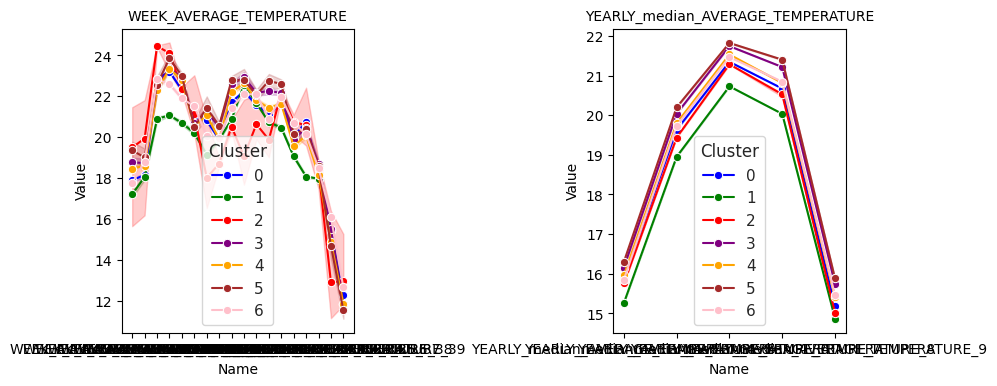

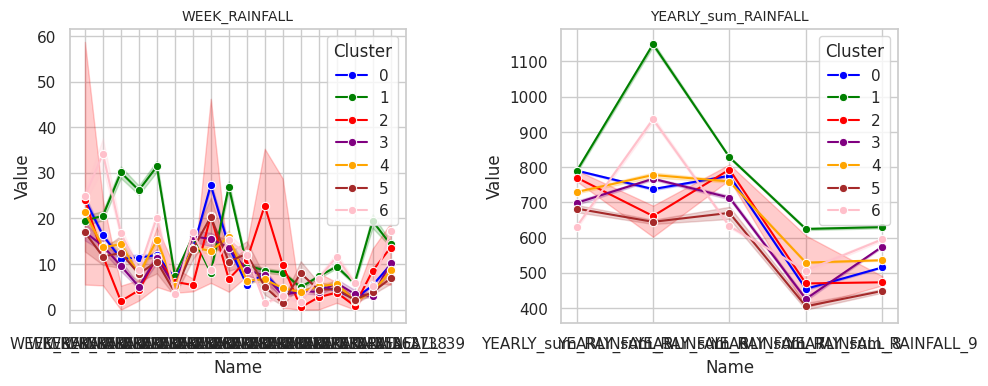

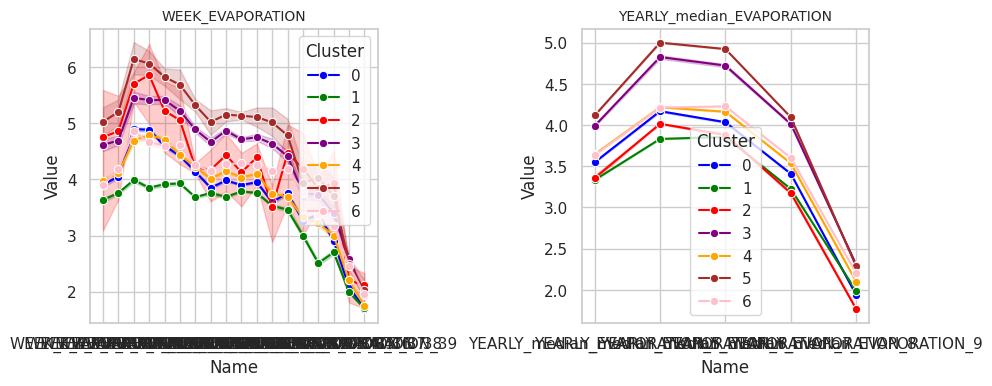

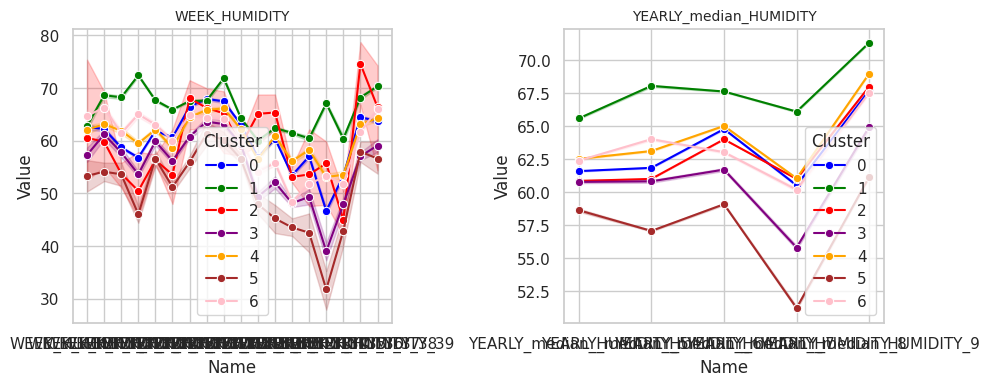

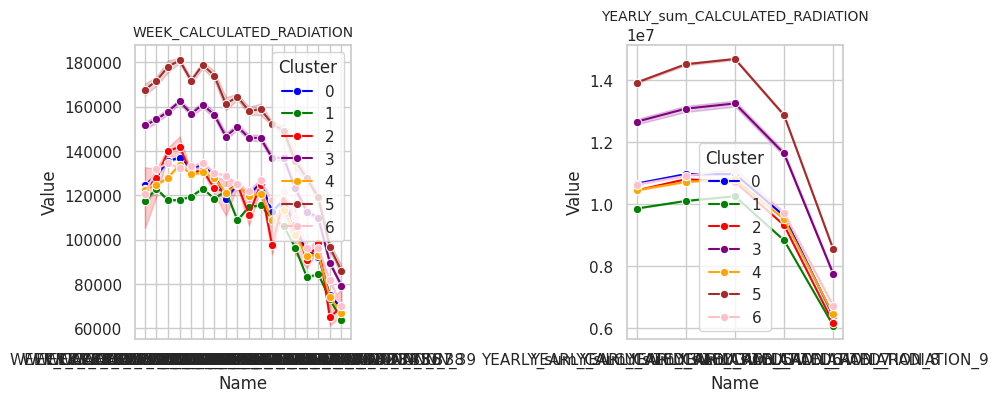

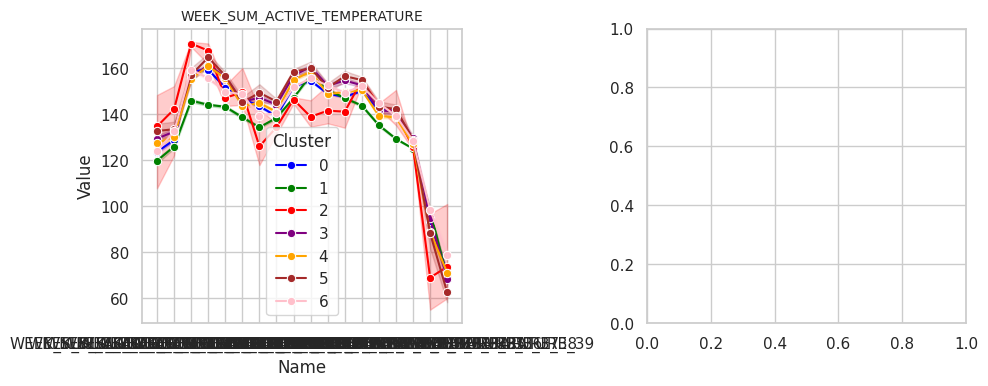

In [12]:
######## VISUALIZE WEATHER FOR UNDERSTANDING DATA ###############################

color_vector = ['blue', 'green', 'red', 'purple', 'orange', 'brown', 'pink']
# color_vector = ['r', 'g', 'b', 'm', 'c', 'y', 'aquamarine']

###### PLOT ORIGINAL WEATHER FOR CLUSTER ###########               
show_check = True
if show_check == True:
    ################# PLOT WEATHER ################################
    for ii, feature_name in enumerate(WEEKLY_FEATURE_NAME_LIST):
        fig, ax = plt.subplots(1, 2, figsize=(10, 4))
        axs = ax.flat
        sns.set(style="whitegrid")
        ############# FOR WEEKLY #####################################################
        cols_names = [f'{feature_name}_{x}' for x in range(22, 40)]
        selected_df = original_data[cols_names + ['Cluster']]
        
        # Melt the DataFrame
        melted_df = pd.melt(selected_df, id_vars=['Cluster'], var_name='Name', value_name='Value')    
        
        sns.lineplot(x='Name', y='Value', hue='Cluster', 
                     ax=axs[0], data=melted_df, palette=color_vector, 
                     marker='o').set_title(f'{feature_name}', fontsize=10)
        ############### FOR YEARLY #####################################################   
        if ii < len(YEARLY_FEATURE_NAME_LIST):            
            feature_name = YEARLY_FEATURE_NAME_LIST[ii]
            
            cols_names = [f'{feature_name}_{x}' for x in range(5, 10)]
            selected_df = original_data[cols_names + ['Cluster']]
            
            # Melt the DataFrame
            melted_df = pd.melt(selected_df, id_vars=['Cluster'], var_name='Name', value_name='Value')
            
            sns.lineplot(x='Name', y='Value', hue='Cluster', 
                         ax=axs[1], data=melted_df, palette=color_vector, 
                         marker='o').set_title(f'{feature_name}', fontsize=10)

        fig.tight_layout(pad=1)

In [13]:
# ###### Normalize/Standardize WEATHER ###########################
#### use StandartScaler with PCA for each Geozone or each Cluste r########

################# TODO ##############################################################      
##### Explain TODO's: because the growth process of the crops is divided into critical periods, 
#####                 the selection of specific basis function can be more suitable
##### TODO: 1. Discrete Wavelet (Haar‐Wavelets), 2.  Piecewise Aggregate Approximation, 3. Adaptive Piecewise Constant 

################# TODO #############################################################
######## TODO: need to be parralelized with multithreading, because too long execution
######## TODO: scaler.fit_transform for train data only, use scaler.transform for test dataset ##################
######## comment: Geozone aggregation temporaray changed by Cluster aggregation for more fast execution, 

##### MAYBE UNSCALED VARIABLES ###############
# np_data['YEARLY_sum_RAINFALL'] = np_data['YEARLY_sum_RAINFALL'] / 18
# np_data['YEARLY_sum_CALCULATED_RADIATION'] = np_data['YEARLY_sum_CALCULATED_RADIATION'] / 18

######## use CLEAR function for drop understandable data ##########
def clear_df(data):
    ##### !!!!! drop Geozone 42 it contain only test fields or add to Cluster 5 with closer mean Geozone
    data = data[ data['Geozone'] != 42 ]
    
    ##### !!!! drop Cluster 2, only 4 - fields, 1 - test, or add to closer Geozone (may be) 
    data = data[ data['Cluster'] != 2 ]

    return data

##### for fast check pipline, used later #############
ORIGINAL_DATA = original_data.copy()
####

original_data = clear_df(original_data)

def get_PCA(data, weather_feature, threshold=0.999, ):
    # # Standardize the data (mean=0 and variance=1)
    # scaler = StandardScaler()
    # scaled_data = scaler.fit_transform(df)
    
    # Apply PCA
    # Fit PCA to the data
    pca = PCA()
    pca.fit(data)

    # Determine the number of components based on the explained variance
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    num_components = np.argmax(cumulative_variance >= threshold) + 1

    # Use the determined number of components
    pca = PCA(n_components=num_components)
    principal_components = pca.fit_transform(data)
    
    # Create a DataFrame with the principal components
    columns = [f'PCA_{weather_feature}_{i}' for i in range(principal_components.shape[1])]
    pc_df = pd.DataFrame(data=principal_components, columns=columns)
    
    # Concatenate the principal components DataFrame with the original DataFrame
    result_df = pd.concat([scaled_data, pc_df], axis=1)

    return result_df


def ScaleWeatherAOI(df, weather_feature, aggregation_by='Cluster', do_pca=False):
    # Separate data by Geozone
    geozone_data = {}
    for geozone in df[aggregation_by].unique():
        geozone_data[geozone] = df[df[aggregation_by] == geozone].copy()
    
    # Apply StandardScaler for each Geozone on weather columns
    scalers = {}
    scaled_data = pd.DataFrame()  
    
    for geozone, geozone_df in geozone_data.items():
        
        scaler = StandardScaler()
        
        # Select only the weather columns for scaling
        weather_columns = geozone_df.columns[geozone_df.columns.str.startswith(f'{weather_feature}_')]
        scaled_weather = scaler.fit_transform(geozone_df[weather_columns])

        if do_pca == True:
            pca_weather = get_PCA(scaled_weather, weather_feature, threshold=0.95,)
        
        # Store the scaler for later use if needed
        scalers[geozone] = scaler
        
        # Append the scaled data to the overall result
        if do_pca == True:
            scaled_data = pd.concat([scaled_data, pca_weather], ignore_index=True)
        else:
            # Replace the original weather columns with scaled values
            geozone_df[weather_columns] = scaled_weather
            scaled_data = pd.concat([scaled_data, geozone_df], ignore_index=True)
            
    return scaled_data

scaled_data = original_data

##### Scale and PCA's WEEKLY WEATHER FEATURES
for weekly_future in WEEKLY_FEATURE_NAME_LIST:
    scaled_data = ScaleWeatherAOI(scaled_data, weekly_future)

# Display the result
display(scaled_data)

#### for further steps ####
original_data = scaled_data

Dataset  Field  Year  Cluster     Area       Yield  Geozone  Predecessor  \
0      train   1310  2019        1   79.263  129.077355       12            0   
1      train   1315  2018        1  115.484  190.068235       12            0   
2      train   1315  2019        1   83.883  149.674818       12            0   
3      train   1312  2018        1   55.964  181.336145       12            0   
4      train   1312  2019        1   55.965  148.165017       12            0   
...      ...    ...   ...      ...      ...         ...      ...          ...   
7913    test    286  2020        6   31.115    0.000000       19            1   
7914    test    305  2020        6  106.814    0.000000       19            1   
7915    test    292  2020        6   64.673    0.000000       19            1   
7916    test    291  2020        6   34.607    0.000000       19            1   
7917    test   2743  2020        6   30.444    0.000000       25            0   

        FAO           N  ...  YEARLY_median_HUMIDITY_5  \
0     320.0  222.330633  ...                      65.0   
1     360.0  202.932162  ...                      65.0   
2     320.0  229.686158  ...                      65.0   
3     360.0  209.345544  ...                      65.0   
4     320.0  204.983972  ...                      65.0   
...     ...         ...  ...                       ...   
7913  360.0  187.876105  ...                      63.0   
7914  360.0  192.701593  ...                      63.0   
7915  360.0  189.152769  ...                      63.0   
7916  360.0  187.967348  ...                      63.0   
7917    NaN  170.663185  ...                      62.0   

      YEARLY_median_HUMIDITY_6  YEARLY_median_HUMIDITY_7  \
0                         67.0                      67.0   
1                         67.0                      67.0   
2                         67.0                      67.0   
3                         67.0                      67.0   
4                         67.0                      67.0   
...                        ...                       ...   
7913                      64.0                      63.0   
7914                      64.0                      63.0   
7915                      64.0                      63.0   
7916                      64.0                      63.0   
7917                      64.0                      63.0   

      YEARLY_median_HUMIDITY_8  YEARLY_median_HUMIDITY_9  \
0                         65.0                      71.0   
1                         65.0                      71.0   
2                         65.0                      71.0   
3                         65.0                      71.0   
4                         65.0                      71.0   
...                        ...                       ...   
7913                      61.0                      68.0   
7914                      61.0                      68.0   
7915                      61.0                      68.0   
7916                      61.0                      68.0   
7917                      61.0                      68.0   

      YEARLY_sum_CALCULATED_RADIATION_5  YEARLY_sum_CALCULATED_RADIATION_6  \
0                             9779661.0                         10016516.0   
1                             9779661.0                         10016516.0   
2                             9779661.0                         10016516.0   
3                             9779661.0                         10016516.0   
4                             9779661.0                         10016516.0   
...                                 ...                                ...   
7913                         10689032.0                         11052625.0   
7914                         10689032.0                         11052625.0   
7915                         10689032.0                         11052625.0   
7916                         10689032.0                         11052625.0   
7917                         103253

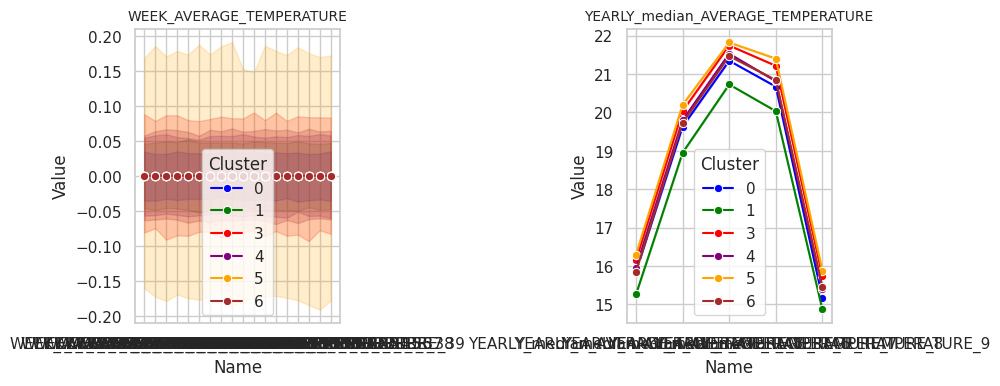

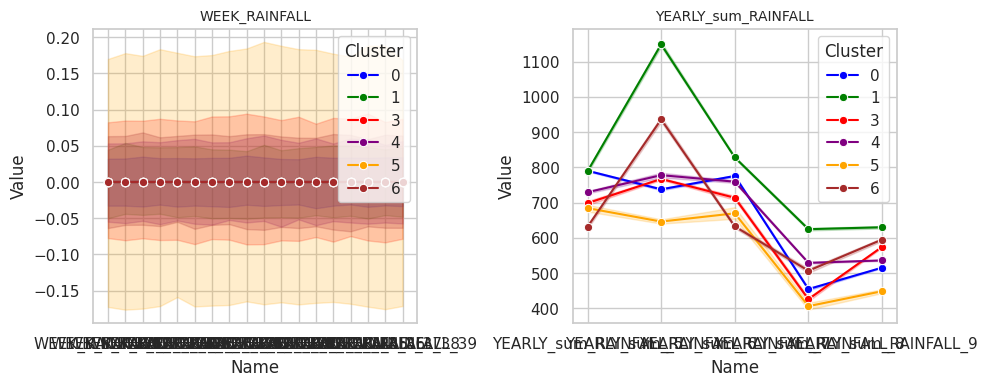

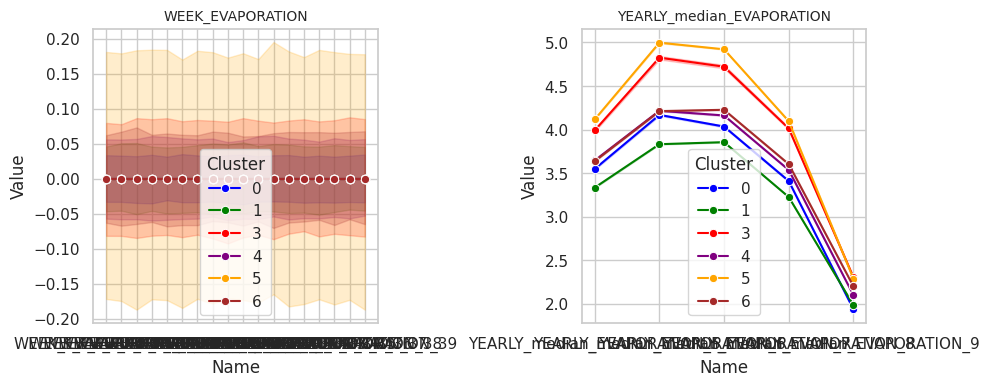

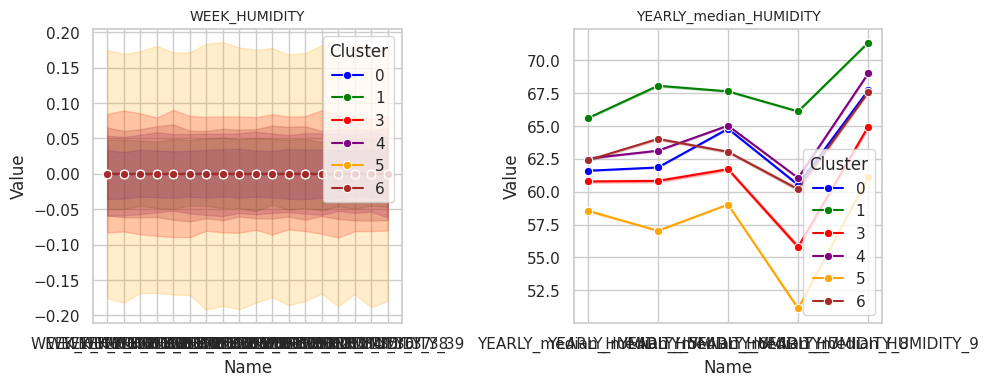

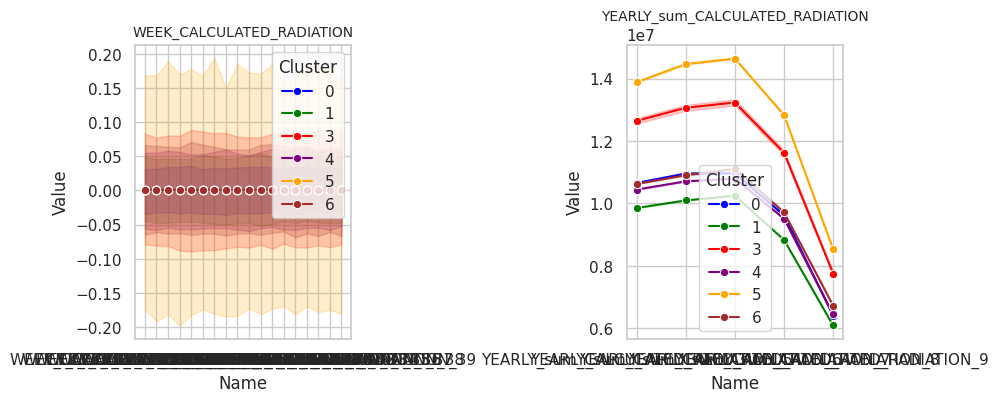

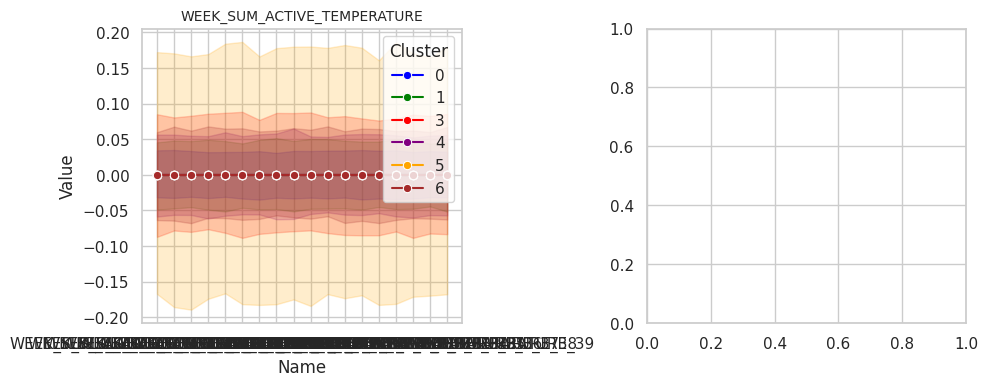

In [14]:
######## VISUALIZE DATASET FOR UNDERSTANDING SCALED DATA ###############################

color_vector = ['blue', 'green', 'red', 'purple', 'orange', 'brown'] #, 'pink']
# color_vector = ['r', 'g', 'b', 'm', 'c', 'y', 'aquamarine']

###### PLOT SCALED WEATHER FOR CLUSTER/GEOZONE ###########               
# show_check = True
if show_check == True:
    ################# PLOT WEATHER ################################
    for ii, feature_name in enumerate(WEEKLY_FEATURE_NAME_LIST):
        fig, ax = plt.subplots(1, 2, figsize=(10, 4))
        axs = ax.flat
        sns.set(style="whitegrid")
        ############# FOR WEEKLY #####################################################
        cols_names = [f'{feature_name}_{x}' for x in range(22, 40)]
        selected_df = original_data[cols_names + ['Cluster']]
        
        # Melt the DataFrame
        melted_df = pd.melt(selected_df, id_vars=['Cluster'], var_name='Name', value_name='Value')    
        
        sns.lineplot(x='Name', y='Value', hue='Cluster', 
                     ax=axs[0], data=melted_df, palette=color_vector, 
                     marker='o').set_title(f'{feature_name}', fontsize=10)
        ############### FOR YEARLY #####################################################   
        if ii < len(YEARLY_FEATURE_NAME_LIST):            
            feature_name = YEARLY_FEATURE_NAME_LIST[ii]
            
            cols_names = [f'{feature_name}_{x}' for x in range(5, 10)]
            selected_df = original_data[cols_names + ['Cluster']]
            
            # Melt the DataFrame
            melted_df = pd.melt(selected_df, id_vars=['Cluster'], var_name='Name', value_name='Value')
            
            sns.lineplot(x='Name', y='Value', hue='Cluster', 
                         ax=axs[1], data=melted_df, palette=color_vector, 
                         marker='o').set_title(f'{feature_name}', fontsize=10)

        fig.tight_layout(pad=1)

/tmp/ipykernel_266901/3367904087.py:40: UserWarning: 
The palette list has fewer values (6) than needed (42) and will cycle, which may produce an uninterpretable plot.
  sns.violinplot(


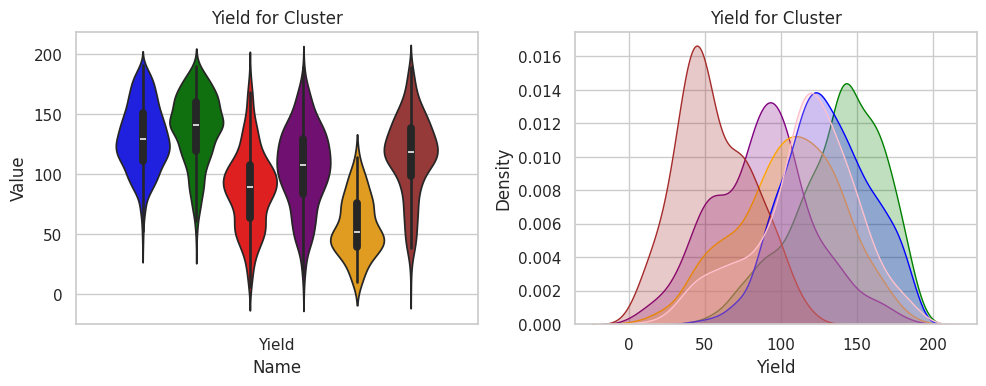

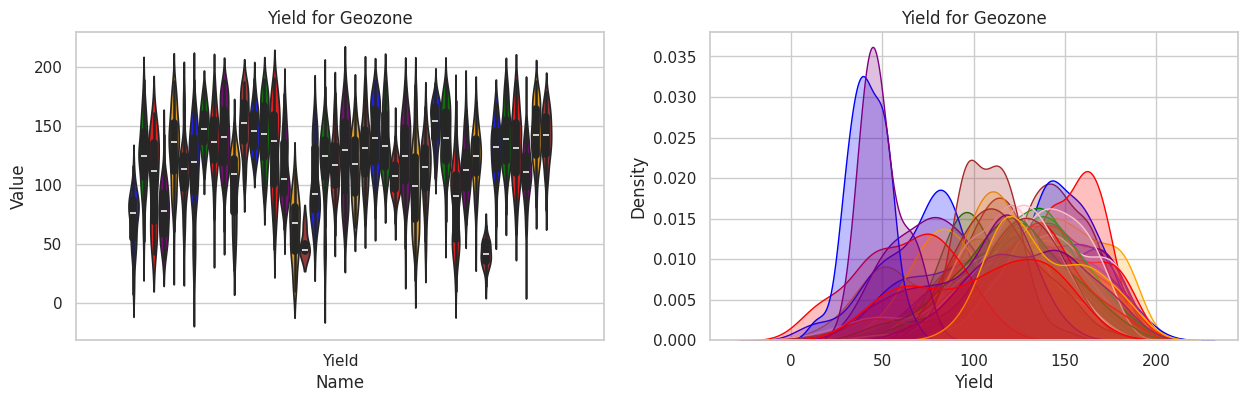

In [15]:
color_vector = ['blue', 'green', 'red', 'purple', 'orange', 'brown', 'pink']

###### PLOT YIELD FOR CLUSTER & GEOZONE ################
# show_check = True
if show_check == True:
    ######################## PLOT YIELD FOR CLUSTER ################
    fix, ax = plt.subplots(1, 2, figsize=(10, 4))
    axs = ax.flat
    ##### FOR YIELD #################
    cols_names = ['Yield']
    selected_df = original_data.loc[(original_data['Dataset'] == 'train'), cols_names + ['Cluster']]
    
    # Melt the DataFrame
    melted_df = pd.melt(selected_df, id_vars=['Cluster'], var_name='Name', value_name='Value')
    
    sns.set(style="whitegrid")
    sns.violinplot(
        data=melted_df, x="Name", y="Value", hue="Cluster", palette=color_vector[0:6], ax=axs[0],  legend=False,
    ).set_title('Yield for Cluster')
    # sns.scatterplot(data=melted_df, x='Name', y='Value', hue='Cluster', ax=ax,  
    #                 palette=color_vector, marker='.', legend=False).set_title(f'{feature_name}', fontsize=10)
    
    for ii in selected_df['Cluster'].unique():
        sns.kdeplot(data=selected_df[ selected_df['Cluster'] == ii ], x='Yield', fill=True, ax=axs[1], color=color_vector[ii]).set_title('Yield for Cluster');

    fix.tight_layout(pad=1)
    ######################## PLOT YIELD FOR GEOZONE ################
    fix, ax = plt.subplots(1, 2, figsize=(15, 4))
    axs = ax.flat
    ##### FOR YIELD #################
    cols_names = ['Yield']
    selected_df = original_data.loc[(original_data['Dataset'] == 'train'), cols_names + ['Geozone']]
    
    # Melt the DataFrame
    melted_df = pd.melt(selected_df, id_vars=['Geozone'], var_name='Name', value_name='Value')

    color_vectors = color_vector * 10 
    
    sns.set(style="whitegrid")
    sns.violinplot(
        data=melted_df, x="Name", y="Value", hue="Geozone", palette=color_vector[0:6], ax=axs[0],  legend=False,
    ).set_title('Yield for Geozone')
    # sns.scatterplot(data=melted_df, x='Name', y='Value', hue='Cluster', ax=ax,  
    #                 palette=color_vector, marker='.', legend=False).set_title(f'{feature_name}', fontsize=10)

    for ii in selected_df['Geozone'].unique():
        sns.kdeplot(data=selected_df[ selected_df['Geozone'] == ii ], x='Yield', fill=True, ax=axs[1], color=color_vectors[ii]).set_title('Yield for Geozone');


In [16]:
#### TODO: CALCULATE _CUMSUM_ FOR WEATHER FEATURES #############################
#### SOME CUMSUMS MAY BE USEFULL WEATHER FEATURE, for stochastic variables such as rainfall, for example

cumsum_data = original_data.copy()

for feature_name in WEEKLY_FEATURE_NAME_LIST:            
    wz_name_columns = cumsum_data.columns[cumsum_data.columns.str.match(f'{feature_name}_\d')]
    cumsum_data[wz_name_columns] = cumsum_data[wz_name_columns].cumsum(axis=1)

display(cumsum_data)

# ###### CHECK&VIZUALIZE CUMSUMS FEATURES ################
# if show_check == True:
#     ###### PLOT WEEKLY ###########
#     fix, ax = plt.subplots(3, 2, figsize=(15, 10))
#     axs = ax.flat
#     for ii, feature_name in enumerate(WEEKLY_FEATURE_NAME_LIST):
#         ##### FOR WEEKLY #################
#         cols_names = [f'cumsum_{feature_name}_{x}' for x in nums_weeks[10:]]
#         # cols_names = [f'cumsum_{feature_name}']
#         selected_df = cumsum_data[cols_names + ['Cluster']]
        
#         # Melt the DataFrame
#         melted_df = pd.melt(selected_df, id_vars=['Cluster'], var_name='Name', value_name='Value')
        
#         # Plot using seaborn lineplot
#         sns.set(style="whitegrid")
#         # cols_names = [f'{feature_name}_{x}' for x in range(32, 40)]
#         sns.lineplot(x='Name', y='Value', hue='Cluster', ax=axs[ii], data=melted_df, palette=color_vector, marker='o').set_title(f'{feature_name}', fontsize=10)


Dataset  Field  Year  Cluster     Area       Yield  Geozone  Predecessor  \
0      train   1310  2019        1   79.263  129.077355       12            0   
1      train   1315  2018        1  115.484  190.068235       12            0   
2      train   1315  2019        1   83.883  149.674818       12            0   
3      train   1312  2018        1   55.964  181.336145       12            0   
4      train   1312  2019        1   55.965  148.165017       12            0   
...      ...    ...   ...      ...      ...         ...      ...          ...   
7913    test    286  2020        6   31.115    0.000000       19            1   
7914    test    305  2020        6  106.814    0.000000       19            1   
7915    test    292  2020        6   64.673    0.000000       19            1   
7916    test    291  2020        6   34.607    0.000000       19            1   
7917    test   2743  2020        6   30.444    0.000000       25            0   

        FAO           N  ...  YEARLY_median_HUMIDITY_5  \
0     320.0  222.330633  ...                      65.0   
1     360.0  202.932162  ...                      65.0   
2     320.0  229.686158  ...                      65.0   
3     360.0  209.345544  ...                      65.0   
4     320.0  204.983972  ...                      65.0   
...     ...         ...  ...                       ...   
7913  360.0  187.876105  ...                      63.0   
7914  360.0  192.701593  ...                      63.0   
7915  360.0  189.152769  ...                      63.0   
7916  360.0  187.967348  ...                      63.0   
7917    NaN  170.663185  ...                      62.0   

      YEARLY_median_HUMIDITY_6  YEARLY_median_HUMIDITY_7  \
0                         67.0                      67.0   
1                         67.0                      67.0   
2                         67.0                      67.0   
3                         67.0                      67.0   
4                         67.0                      67.0   
...                        ...                       ...   
7913                      64.0                      63.0   
7914                      64.0                      63.0   
7915                      64.0                      63.0   
7916                      64.0                      63.0   
7917                      64.0                      63.0   

      YEARLY_median_HUMIDITY_8  YEARLY_median_HUMIDITY_9  \
0                         65.0                      71.0   
1                         65.0                      71.0   
2                         65.0                      71.0   
3                         65.0                      71.0   
4                         65.0                      71.0   
...                        ...                       ...   
7913                      61.0                      68.0   
7914                      61.0                      68.0   
7915                      61.0                      68.0   
7916                      61.0                      68.0   
7917                      61.0                      68.0   

      YEARLY_sum_CALCULATED_RADIATION_5  YEARLY_sum_CALCULATED_RADIATION_6  \
0                             9779661.0                         10016516.0   
1                             9779661.0                         10016516.0   
2                             9779661.0                         10016516.0   
3                             9779661.0                         10016516.0   
4                             9779661.0                         10016516.0   
...                                 ...                                ...   
7913                         10689032.0                         11052625.0   
7914                         10689032.0                         11052625.0   
7915                         10689032.0                         11052625.0   
7916                         10689032.0                         11052625.0   
7917                         103253

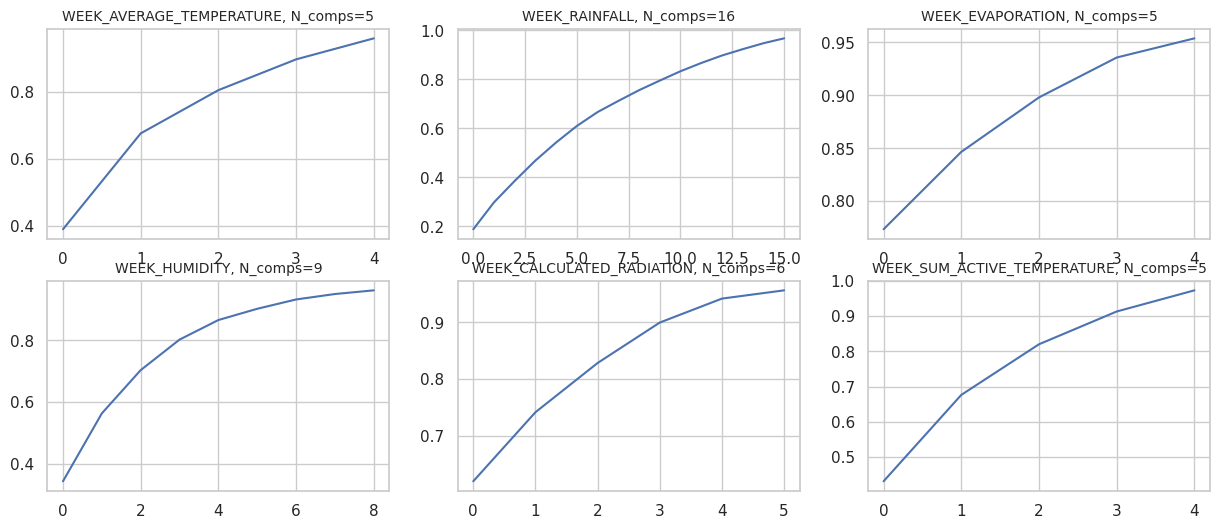

In [17]:
##### EOF(Principal Components) FOR WHOLE DATASET for each wather time series feature #############################
##### usefull for fast checck pipline ####################

###############################################################################      
##### TODO: 1. Discrete Wavelet, Haar‐Wavelets, 2.  Piecewise Aggregate Approximation, 3. Adaptive Piecewise Constant 
##### Explain TODO's: because the growth process of the crops is divided into critical periods, 
#####                 the selection of specific bases function can be more suitable

from sklearn.decomposition import PCA

###### FOR EOF(PCA) DECOMPOSITUION ######################
def get_PCA(data_, ax, feature_name='', threshold=0.95):
    # TODO: Initialize PCA without specifying the number of components
    
    # Standardize the data (mean=0 and variance=1)    
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data_) 
    
    pca = PCA()
    
    # Fit PCA to the data
    pca.fit(scaled_data)
    
    # Determine the number of components based on the explained variance
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    num_components = np.argmax(cumulative_variance >= threshold) + 1
    
    # Use the determined number of components or set its manualy
    pca = PCA(n_components=num_components)
    principal_components = pca.fit_transform(scaled_data)
    
    if num_components > 1:
        sns.lineplot(data=np.cumsum(pca.explained_variance_ratio_), ax=ax).set_title(f'{feature_name}, N_comps={num_components}', fontsize=10);
    else:
        sns.scatterplot(data=np.cumsum(pca.explained_variance_ratio_), ax=ax).set_title(f'{feature_name}, N_comps={num_components}', fontsize=10);

    columns = [f'PCA_{feature_name}_{i}' for i in range(principal_components.shape[1])]
    return pd.DataFrame(data=principal_components, columns=columns)

######## PCA FOR EACH WEATHER VARIABLES SEPARETELY #######
def get_EOF_DATA(dataset):
    fix, ax = plt.subplots(2, 3, figsize=(15, 6))
    axs = ax.flat

    data = pd.DataFrame([])
    pc_WEEK_FEATURE_list = []
    for ii, feature_name in enumerate(WEEKLY_FEATURE_NAME_LIST):
        feature_name_columns = dataset.columns[dataset.columns.str.match(f'{feature_name}_\d')]
        data = pd.concat([data, get_PCA(dataset[feature_name_columns], axs[ii], feature_name, threshold=0.95)], axis=1)

    return pd.concat([dataset[FEATURE_NAME_LIST], data], axis=1)

pca_data = get_EOF_DATA(ORIGINAL_DATA)



In [18]:
display('PCA Dataset:', pca_data)

'PCA Dataset:'

Dataset  Field  Year  Cluster     Area       Yield  Geozone  Predecessor  \
0      train   1310  2019        1   79.263  129.077355       12            0   
1      train   1315  2018        1  115.484  190.068235       12            0   
2      train   1315  2019        1   83.883  149.674818       12            0   
3      train   1312  2018        1   55.964  181.336145       12            0   
4      train   1312  2019        1   55.965  148.165017       12            0   
...      ...    ...   ...      ...      ...         ...      ...          ...   
7921    test   2743  2020        6   30.444    0.000000       25            0   
7922    test   3002  2020        5  102.733    0.000000       42            1   
7923    test   3000  2020        5  111.347    0.000000       42            1   
7924    test   3001  2020        5  152.212    0.000000       42            1   
7925    test   2999  2020        5   64.231    0.000000       42            1   

        FAO           N  ...  PCA_WEEK_CALCULATED_RADIATION_1  \
0     320.0  222.330633  ...                        -0.820564   
1     360.0  202.932162  ...                         1.713282   
2     320.0  229.686158  ...                        -0.820564   
3     360.0  209.345544  ...                         1.713282   
4     320.0  204.983972  ...                        -0.820564   
...     ...         ...  ...                              ...   
7921    NaN  170.663185  ...                        -2.275293   
7922  320.0  106.382623  ...                        -1.770929   
7923  320.0  100.968073  ...                        -1.770929   
7924  320.0  103.299175  ...                        -1.770929   
7925  320.0  102.993072  ...                        -1.770929   

      PCA_WEEK_CALCULATED_RADIATION_2  PCA_WEEK_CALCULATED_RADIATION_3  \
0                            0.576804                        -0.754909   
1                           -1.420805                        -0.039980   
2                            0.576804                        -0.754909   
3                           -1.420805                        -0.039980   
4                            0.576804                        -0.754909   
...                               ...                              ...   
7921                        -1.438538                         1.201736   
7922                        -0.304753                         0.285267   
7923                        -0.304753                         0.285267   
7924                        -0.304753                         0.285267   
7925                        -0.304753                         0.285267   

      PCA_WEEK_CALCULATED_RADIATION_4  PCA_WEEK_CALCULATED_RADIATION_5  \
0                           -0.150005                         0.836909   
1                           -0.708859                         0.024135   
2                           -0.150005                         0.836909   
3                           -0.708859                         0.024135   
4                           -0.150005                         0.836909   
...                               ...                              ...   
7921                        -0.564508                         0.615288   
7922                         0.368658                         0.166772   
7923                         0.368658                         0.166772   
7924                         0.368658                         0.166772   
7925                         0.368658                         0.166772   

      PCA_WEEK_SUM_ACTIVE_TEMPERATURE_0  PCA_WEEK_SUM_ACTIVE_TEMPERATURE_1  \
0                             -2.007467                           2.134954   
1                              2.223901                           0.544241   
2                             -2.007467                           2.134954   
3                              2.223901                           0.544241   
4                             -2.007467                           2.134954   
...  

In [19]:
##### COMBINE FEATURES FROM ORIGINAL, CUMSUM, PCA, AND OTHER FEATUREs DATASET ##########################
##### USEFUL FOR FEATURE IMPORTANCE ##############################

FEATURE_NAME_LIST = ['Dataset', 'Field', 'Year', 'Cluster', 'Area', 'Yield', 'Geozone', 'Predecessor', 'FAO', 'N', 'P', 'K']

WEEKLY_FEATURE_NAME_LIST = ['WEEK_AVERAGE_TEMPERATURE', 'WEEK_RAINFALL', 'WEEK_EVAPORATION', 'WEEK_HUMIDITY', 'WEEK_CALCULATED_RADIATION', 'WEEK_SUM_ACTIVE_TEMPERATURE', ]

YEARLY_FEATURE_NAME_LIST = ['YEARLY_median_AVERAGE_TEMPERATURE', 'YEARLY_sum_RAINFALL', 'YEARLY_median_EVAPORATION', 'YEARLY_median_HUMIDITY',   'YEARLY_sum_CALCULATED_RADIATION', ]

def get_FEATURE_COLUMNS(df, column_patterns, prefixs = 'PCA_', suff=''):
    prefixed_column_names = [prefixs + name for name in column_patterns]
    
    regex_pattern = '|'.join(prefixed_column_names)
    
    selected_columns = list(df.filter(regex=f'{regex_pattern}_{suff}'))

    FEATURE_COLUMNS = FEATURE_NAME_LIST + selected_columns
    
    return df[FEATURE_COLUMNS].copy()


####### SET FEATURES FOR TRAINING EXPERIMENTS ############################
column_patterns = ['WEEK_AVERAGE_TEMPERATURE', 'WEEK_RAINFALL']

data = pca_data
# data = scaled_data

data_data = get_FEATURE_COLUMNS(data, column_patterns, 'PCA_', )

display('Combined for train Dataset:', data_data)

'Combined for train Dataset:'

Dataset  Field  Year  Cluster     Area       Yield  Geozone  Predecessor  \
0      train   1310  2019        1   79.263  129.077355       12            0   
1      train   1315  2018        1  115.484  190.068235       12            0   
2      train   1315  2019        1   83.883  149.674818       12            0   
3      train   1312  2018        1   55.964  181.336145       12            0   
4      train   1312  2019        1   55.965  148.165017       12            0   
...      ...    ...   ...      ...      ...         ...      ...          ...   
7921    test   2743  2020        6   30.444    0.000000       25            0   
7922    test   3002  2020        5  102.733    0.000000       42            1   
7923    test   3000  2020        5  111.347    0.000000       42            1   
7924    test   3001  2020        5  152.212    0.000000       42            1   
7925    test   2999  2020        5   64.231    0.000000       42            1   

        FAO           N  ...  PCA_WEEK_RAINFALL_6  PCA_WEEK_RAINFALL_7  \
0     320.0  222.330633  ...            -0.310412             2.539740   
1     360.0  202.932162  ...            -0.362056            -0.250815   
2     320.0  229.686158  ...            -0.310412             2.539740   
3     360.0  209.345544  ...            -0.362056            -0.250815   
4     320.0  204.983972  ...            -0.310412             2.539740   
...     ...         ...  ...                  ...                  ...   
7921    NaN  170.663185  ...             1.777406             0.327689   
7922  320.0  106.382623  ...            -0.424417             0.044493   
7923  320.0  100.968073  ...            -0.424417             0.044493   
7924  320.0  103.299175  ...            -0.424417             0.044493   
7925  320.0  102.993072  ...            -0.424417             0.044493   

      PCA_WEEK_RAINFALL_8  PCA_WEEK_RAINFALL_9  PCA_WEEK_RAINFALL_10  \
0               -0.655636             0.557575             -0.379517   
1                1.330279            -0.343780             -0.542347   
2               -0.655636             0.557575             -0.379517   
3                1.330279            -0.343780             -0.542347   
4               -0.655636             0.557575             -0.379517   
...                   ...                  ...                   ...   
7921             0.453119            -1.205627             -1.254129   
7922             0.006906             0.793332              0.778515   
7923             0.006906             0.793332              0.778515   
7924             0.006906             0.793332              0.778515   
7925             0.006906             0.793332              0.778515   

      PCA_WEEK_RAINFALL_11  PCA_WEEK_RAINFALL_12  PCA_WEEK_RAINFALL_13  \
0                -0.476590              1.234538             -0.174132   
1                 0.218719              0.318988             -0.280926   
2                -0.476590              1.234538             -0.174132   
3                 0.218719              0.318988             -0.280926   
4                -0.476590              1.234538             -0.174132   
...                    ...                   ...                   ...   
7921              0.526325             -0.024347             -0.122722   
7922              0.150972              0.323888              0.423649   
7923              0.150972              0.323888              0.423649   
7924              0.150972              0.323888              0.423649   
7925              0.150972              0.323888              0.423649   

      PCA_WEEK_RAINFALL_14  PCA_WEEK_RAINFALL_15  
0                -0.285303              0.697826  
1                -0.119749             -0.458109  
2                -0.285303              0.697826  
3                -0.119749             -0.458109  
4                -0.285303              0.697826  
...                    ...                   ...  
7921              1.232449      

In [20]:
######## CREATE & CLEAN TRAIN/TEST DATSETS for NaNs & duplicates, and drop them ###############
#### TODO: NaNs have been identified only in the FAO, P, and K variables, which are related to agricultural practices. 
####       Gap filling can be performed for P and K by using the average values within each Cluster, Geozone. 
####       For FAO, gap filling can be done by using the most common value within the respective Cluster, Geozone. 

train = data_data[ data_data['Dataset'] == 'train' ]
test = data_data[ data_data['Dataset'] == 'test' ]

data_data = []

def check_nan_dupl(df):
    # check for missing values
    print('-----------------------------------------------------------------')
    print(f'Dataset length: {df.shape[0]}\n')

    print(f'There are {int(df.isna().sum().sum())} missing feature values.')

    # Identify columns with NaN values
    nan_columns = train.columns[df.isna().any()]
    print(f'There are NaN column names: {nan_columns}\n')

    # check for duplicate rows
    n_duplicate_rows = len(df) - len(df.drop_duplicates())
    print(f'There are {int(n_duplicate_rows)} duplicate rows.\n')

    df = df.dropna()
    df = df.drop_duplicates()

    # get length of train and test datasets
    print(f'Cleared Dataset length: {df.shape[0]}')
    print('-----------------------------------------------------------------')

    return df

train = check_nan_dupl(train)
test = check_nan_dupl(test)


-----------------------------------------------------------------
Dataset length: 5734

There are 1352 missing feature values.
There are NaN column names: Index(['FAO', 'P', 'K'], dtype='object')

There are 46 duplicate rows.

Cleared Dataset length: 4613
-----------------------------------------------------------------
-----------------------------------------------------------------
Dataset length: 2192

There are 961 missing feature values.
There are NaN column names: Index(['FAO', 'P', 'K'], dtype='object')

There are 0 duplicate rows.

Cleared Dataset length: 1501
-----------------------------------------------------------------


In [21]:
#### for color generation 
import matplotlib.colors as mcolors
import numpy as np
import matplotlib.pyplot as plt

def generate_color_vector(N, majority_color='blue', colormap='viridis'):
    """
    Generate a vector of colors with a majority color using matplotlib.colors.

    Parameters:
    - N: int, dimension of the color vector.
    - majority_color: str or tuple, color code for the majority color.
    - colormap: str, name of the colormap for the other colors.

    Returns:
    - color_vector: list of RGBA values.
    """
    # Create a colormap for the other colors
    cmap = plt.cm.get_cmap(colormap)

    # Generate a vector of colors
    color_vector = [mcolors.to_rgba(majority_color)] * N

    # Add other colors from the colormap
    for i in range(1, N):
        color_vector[i] = cmap(i / (N - 1))

    return color_vector

# Example usage with 45 dimensions, majority color 'blue', and colormap 'viridis'
N_dim = 45
majority_color = 'red'
colormap_name = 'viridis'

colors = generate_color_vector(N_dim, majority_color, colormap_name)

/tmp/ipykernel_266901/4074330017.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap(colormap)


/tmp/ipykernel_266901/2240098119.py:13: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=train[ train['Geozone'] == ii ], x='Yield', fill=True, ax=axs[1], color=colors[ii]).set_title('Yield for Geozones');


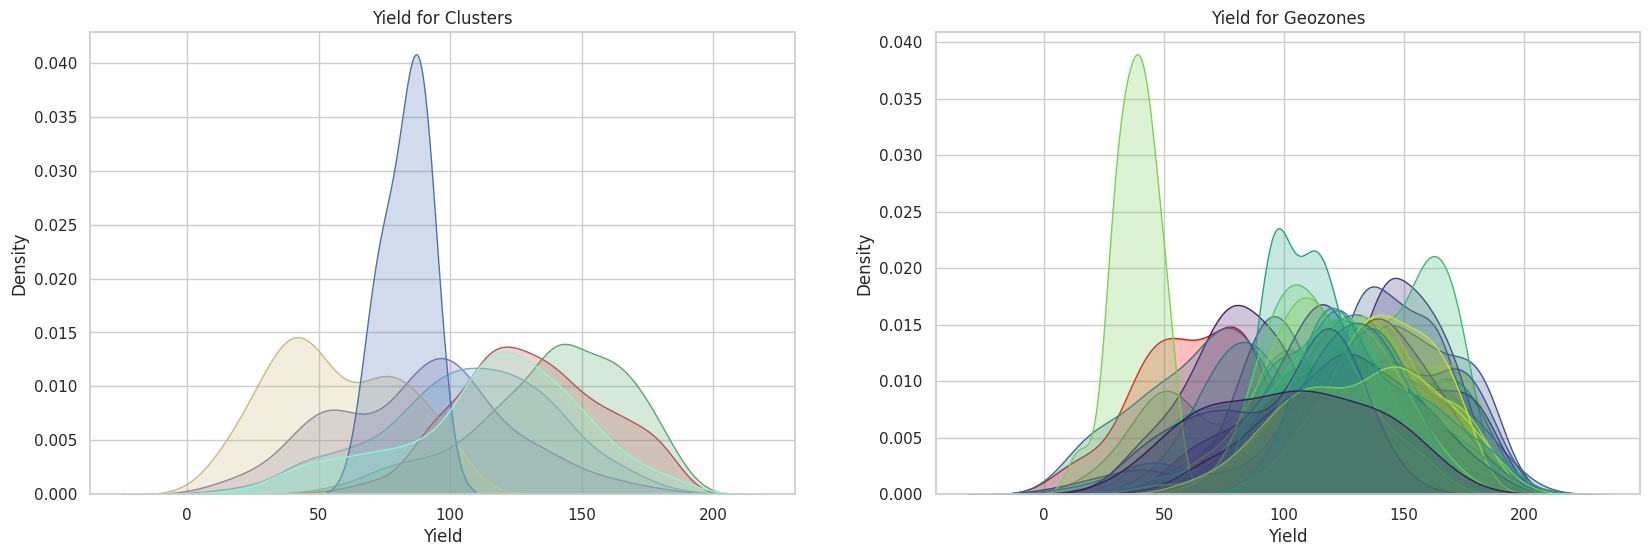

In [22]:
#### CHECK YIELD DISTRIBUTION FOR EACH CLUSTER ###################
colors_clusters = ['r', 'g', 'b', 'm', 'c', 'y', 'aquamarine']

fix, ax = plt.subplots(1, 2, figsize=(20, 6))
axs = ax.flat

for ii in train['Cluster'].unique():
    sns.kdeplot(data=train[ train['Cluster'] == ii ], x='Yield', fill=True, ax=axs[0], color=colors_clusters[ii]).set_title('Yield for Clusters');
axs[0].grid(visible=True)

# fix, ax = plt.subplots(figsize=(6, 6))
for ii in train['Geozone'].unique():
    sns.kdeplot(data=train[ train['Geozone'] == ii ], x='Yield', fill=True, ax=axs[1], color=colors[ii]).set_title('Yield for Geozones');
axs[1].grid(visible=True)

/tmp/ipykernel_266901/3336311597.py:12: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=df_f, x=f'Yield', fill=True, ax=axs[jj], color=colors[ii]).set_title(f'Clust: {jj}; Geos: {num_geozone}, Fields: {df.shape[0]}')


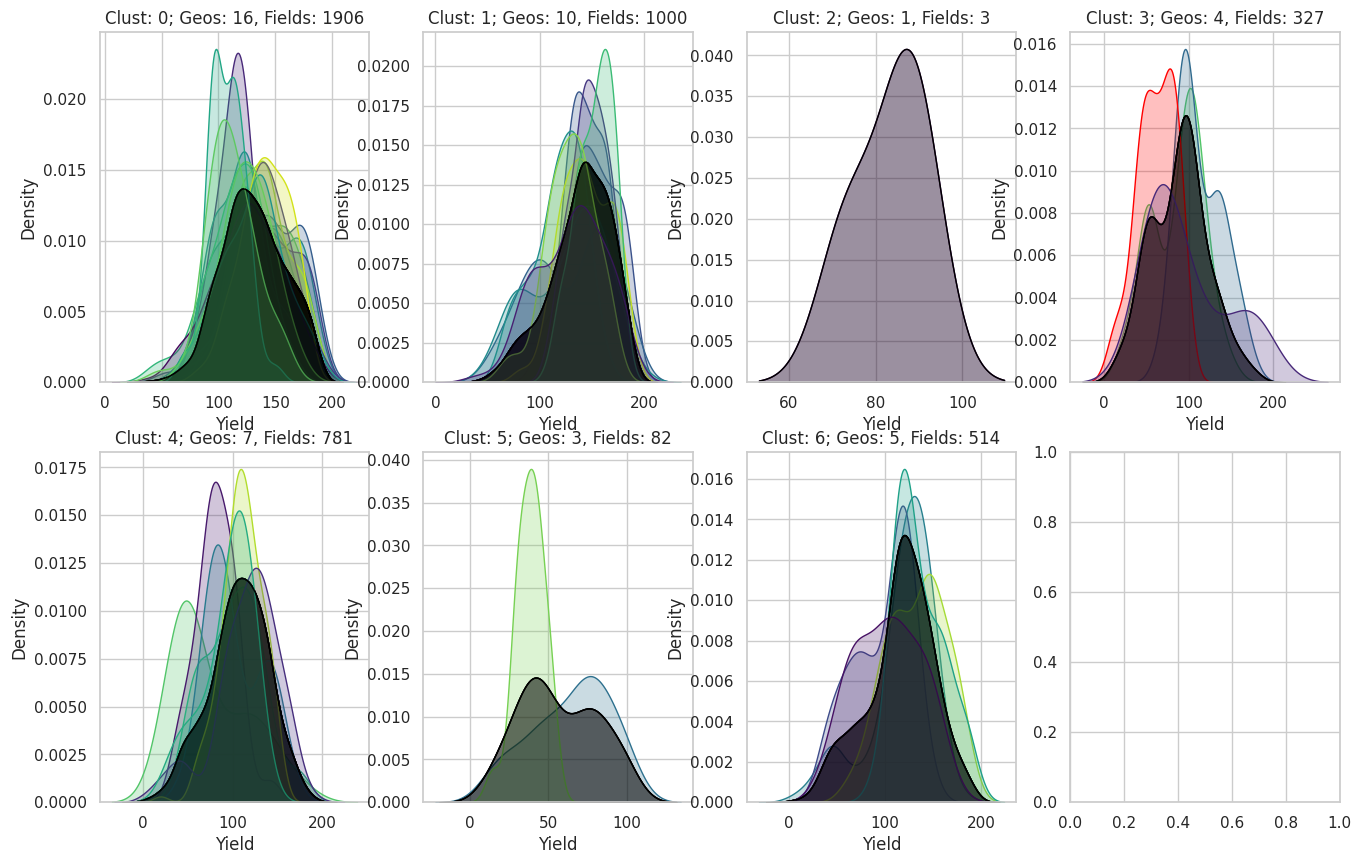

In [23]:
##### CHECK YIELD DISTRIBUTION FOR EACH GEOZONE For EACH CLUSTER #################
# colors = ['r', 'g', 'b', 'm', 'c', 'y', 'aquamarine']

fix, ax = plt.subplots(2, 4, figsize=(16, 10))
axs = ax.flat
for jj in train['Cluster'].unique():
  df = train[ train['Cluster'] == jj ]
  num_geozone = len(df['Geozone'].unique())
  for ii in df['Geozone'].unique():
      df_f = df[ df['Geozone'] == ii ]
      # print('Cluster:', jj, 'Geozone:', ii, 'Fields', df_f.shape[0])
      sns.kdeplot(data=df_f, x=f'Yield', fill=True, ax=axs[jj], color=colors[ii]).set_title(f'Clust: {jj}; Geos: {num_geozone}, Fields: {df.shape[0]}')
      sns.kdeplot(data=df, x='Yield', fill=True, ax=axs[jj], color='black') #.set_title('Target Distribution on Train Set');
  axs[jj].grid(visible=True)


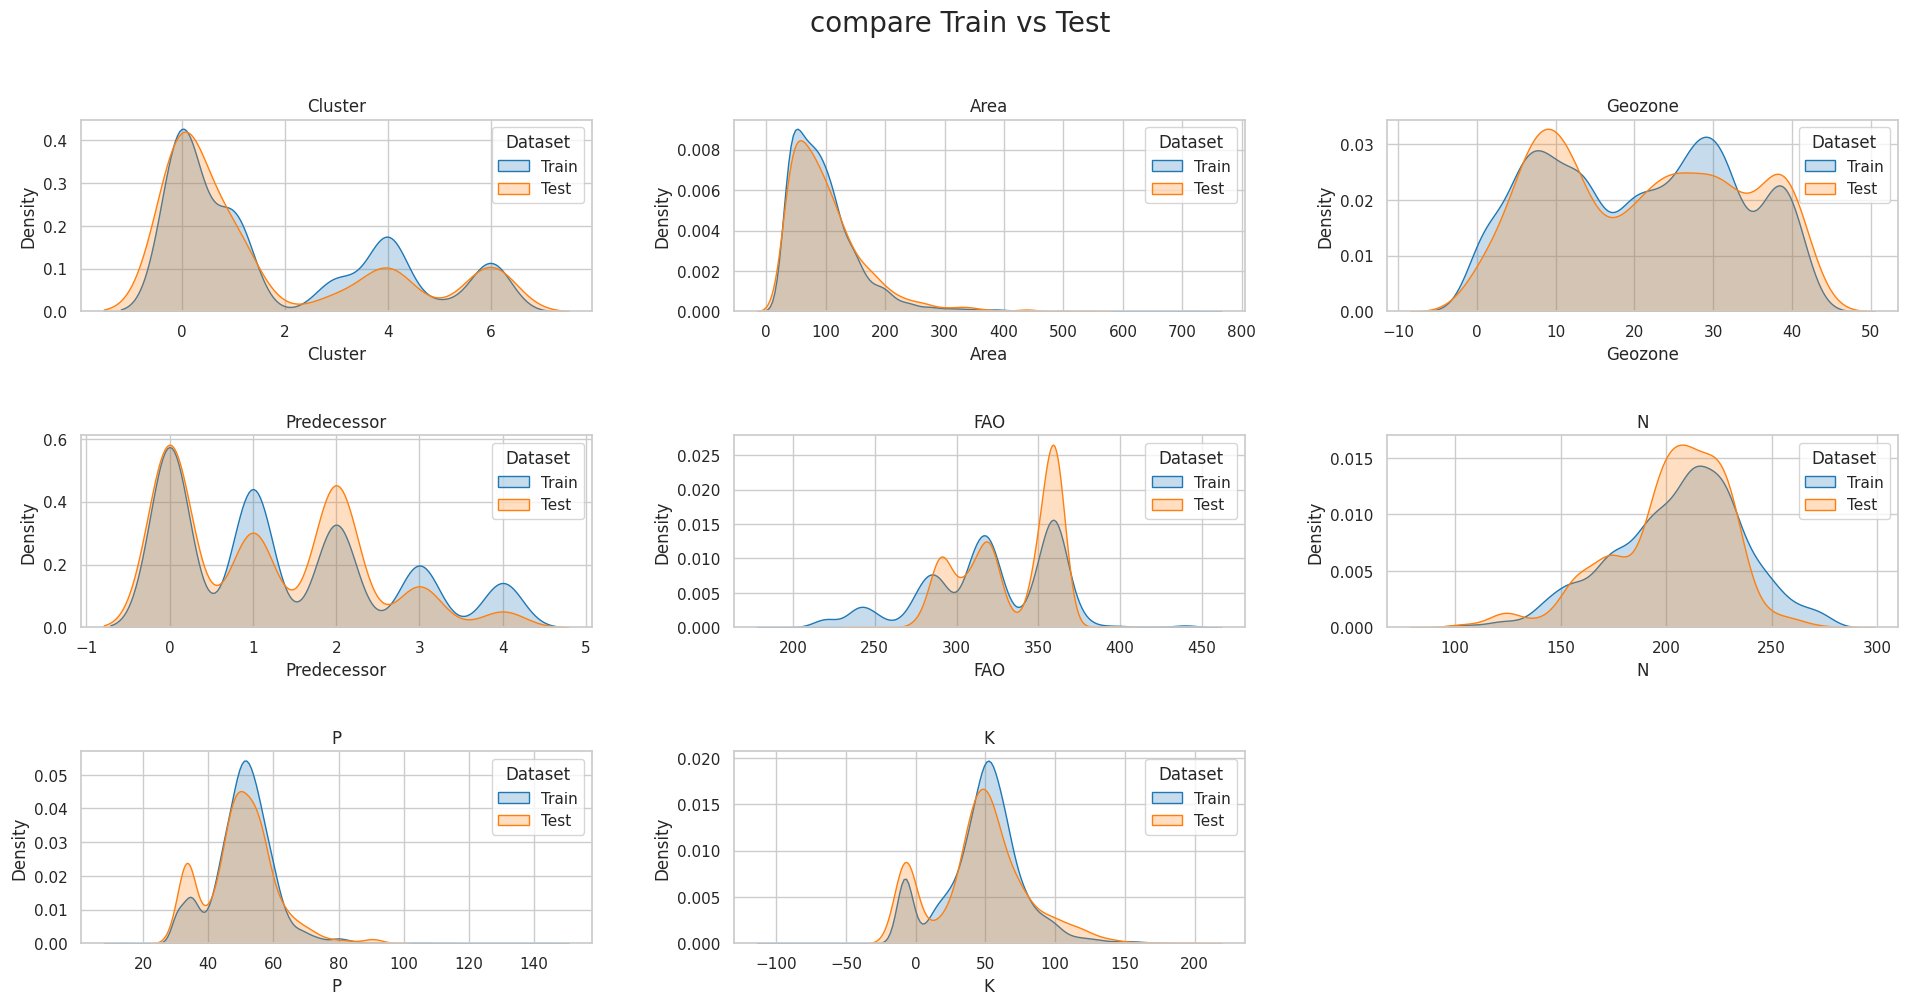

In [24]:
####### COMPARE TRAIN vs TEST DISTRIBUTION ###################################
# features = ['Field', 'Cluster', 'Area', 'Geozone', 'Predecessor', 'FAO', 'N_kg/ga', 'P_kg/ga', 'K_kg/ga']
features = ['Cluster', 'Area', 'Geozone', 'Predecessor', 'FAO', 'N', 'P', 'K']

# plotting distribution of each continuous feature in train and test datasets
fig, ax = plt.subplots(6, 3, figsize=(20, 20))
ax = np.ravel(ax)
palette = sns.color_palette('tab10', 2)

for i, col in enumerate(features):
    sns.kdeplot(data=train, x=train[col], ax=ax[i], label='Train', color=palette[0], fill=True)
    sns.kdeplot(data=test, x=test[col], ax=ax[i], label='Test', color=palette[1], fill=True)
    ax[i].set_title(f'{col}', fontsize=12)
    ax[i].legend(title='Dataset', loc='upper right', labels=['Train', 'Test'])

fig.suptitle('compare Train vs Test', fontsize=20);
fig.tight_layout(pad=3)
for i in range(len(ax)): # hiding any unused axes
    if i >= len(features):
        ax[i].set_visible(False)

There are 11 extreme outliers in the P _kg/ga feature in the training set.
There are 0 extreme outliers in the P _kg/ga feature in the submission set.

There are 457 extreme outliers in the K _kg/ga feature in the training set.
There are 260 extreme outliers in the K _kg/ga feature in the submission set.



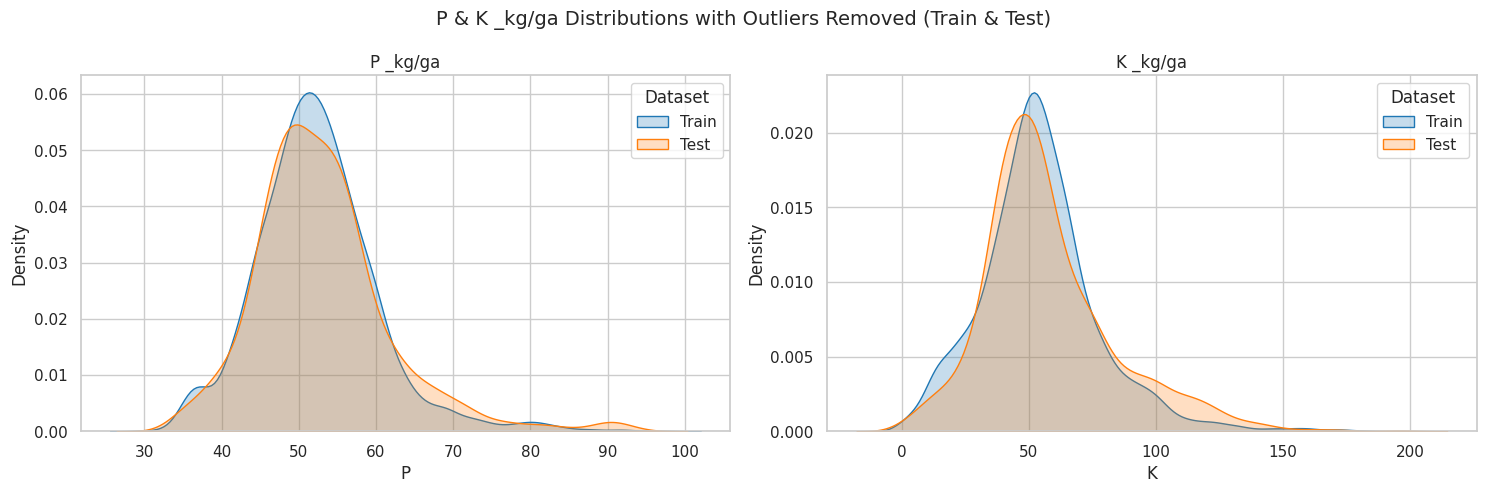

In [25]:
####### CLEANING EXTREAM OUTLIERS #########################
# checking for extreme P & K outliers

P_threshold = 100
n_P_exceeding_train = len(train[train['P'] >= P_threshold])
n_P_exceeding_test = len(test[test['P'] >= P_threshold])
print(f'There are {n_P_exceeding_train} extreme outliers in the P _kg/ga feature in the training set.')
print(f'There are {n_P_exceeding_test} extreme outliers in the P _kg/ga feature in the submission set.\n')

temp_train = train[train['P'] < P_threshold]
temp_test = test[test['P'] < P_threshold]

# checking for extreme K outliers
K_threshold = 0
n_K_exceeding_train = len(temp_train[temp_train['K'] <= K_threshold])
n_K_exceeding_test = len(temp_test[temp_test['K'] <= K_threshold])
print(f'There are {n_K_exceeding_train} extreme outliers in the K _kg/ga feature in the training set.')
print(f'There are {n_K_exceeding_test} extreme outliers in the K _kg/ga feature in the submission set.\n')

temp_train = temp_train[temp_train['K'] > K_threshold]
temp_test = temp_test[temp_test['K'] > K_threshold]

# plotting distribution of each continuous feature in train and test datasets
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax = np.ravel(ax)
palette = sns.color_palette('tab10', 2)

sns.kdeplot(data=temp_train, x=temp_train['P'], ax=ax[0], label='Train', color=palette[0], fill=True)
sns.kdeplot(data=temp_test, x=temp_test['P'], ax=ax[0], label='Test', color=palette[1], fill=True)
ax[0].set_title(f'P _kg/ga', fontsize=12)
ax[0].legend(title='Dataset', loc='upper right', labels=['Train', 'Test'])

sns.kdeplot(data=temp_train, x=temp_train['K'], ax=ax[1], label='Train', color=palette[0], fill=True)
sns.kdeplot(data=temp_test, x=temp_test['K'], ax=ax[1], label='Test', color=palette[1], fill=True)
ax[1].set_title(f'K _kg/ga', fontsize=12)
ax[1].legend(title='Dataset', loc='upper right', labels=['Train', 'Test'])

fig.suptitle('P & K _kg/ga Distributions with Outliers Removed (Train & Test)', fontsize=14);
fig.tight_layout(pad=1)

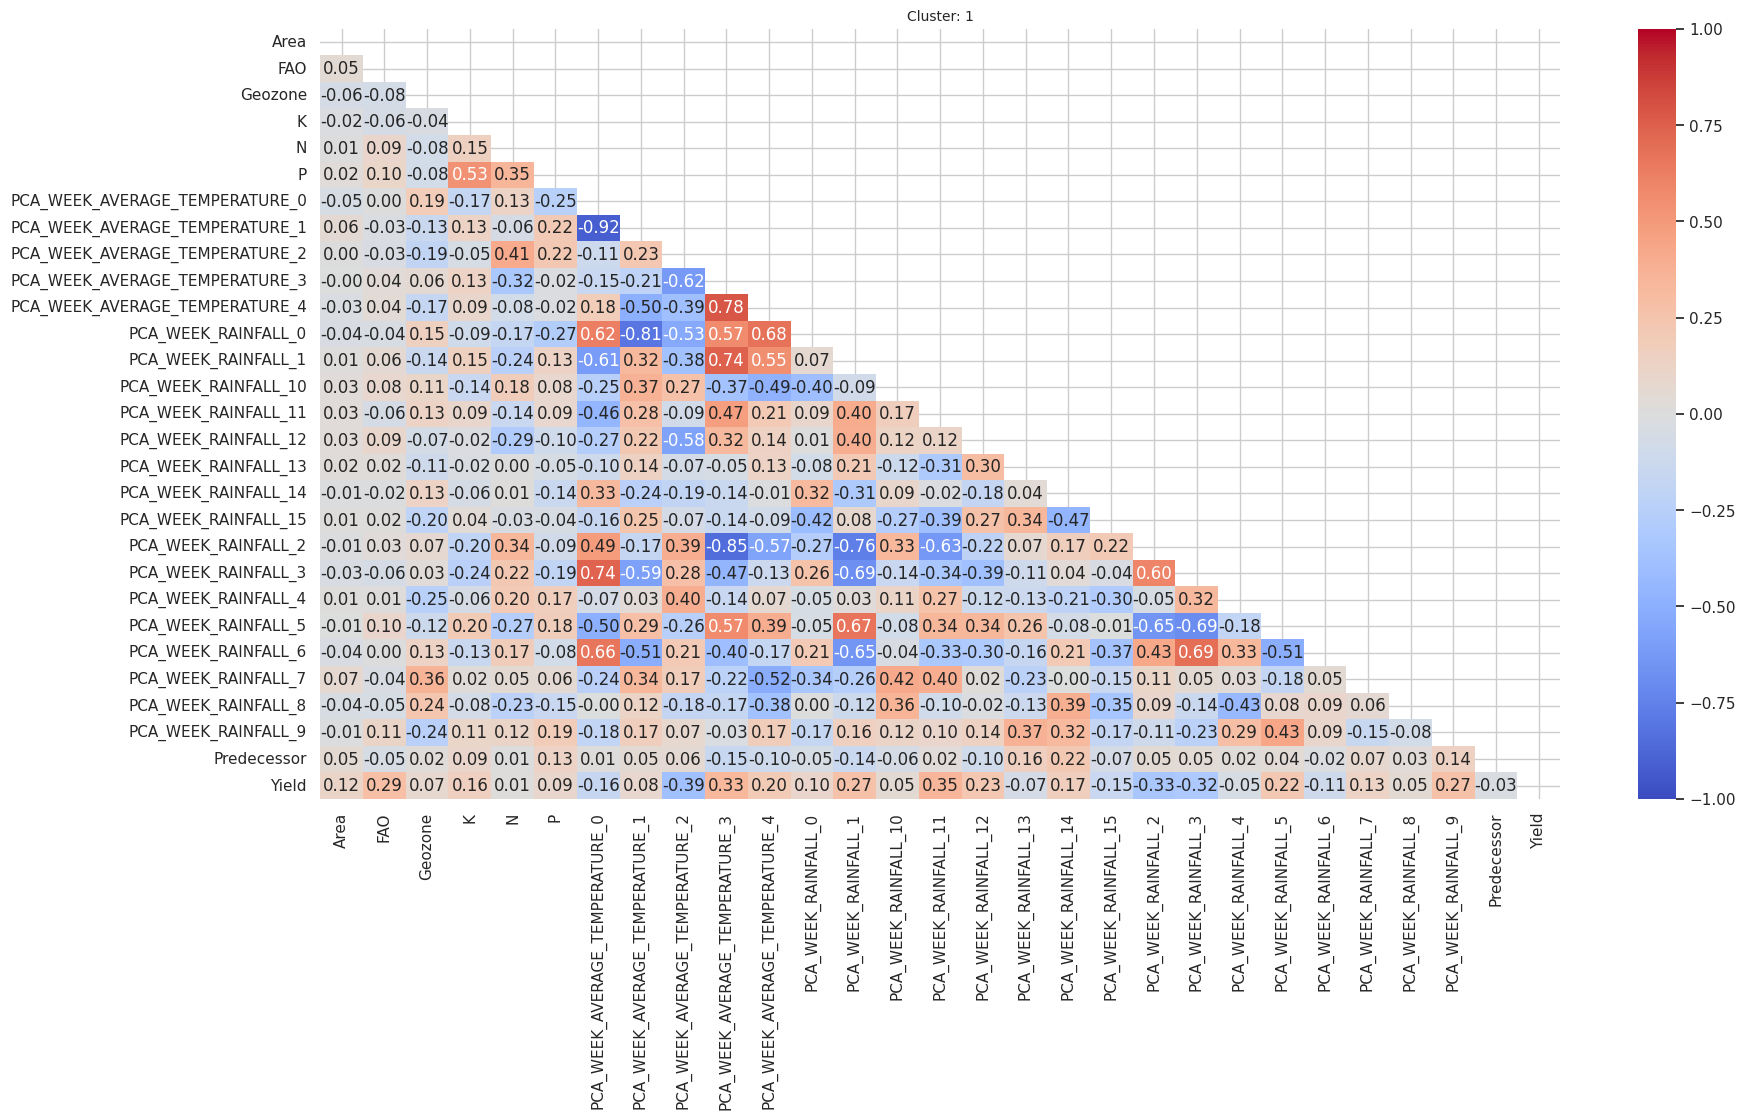

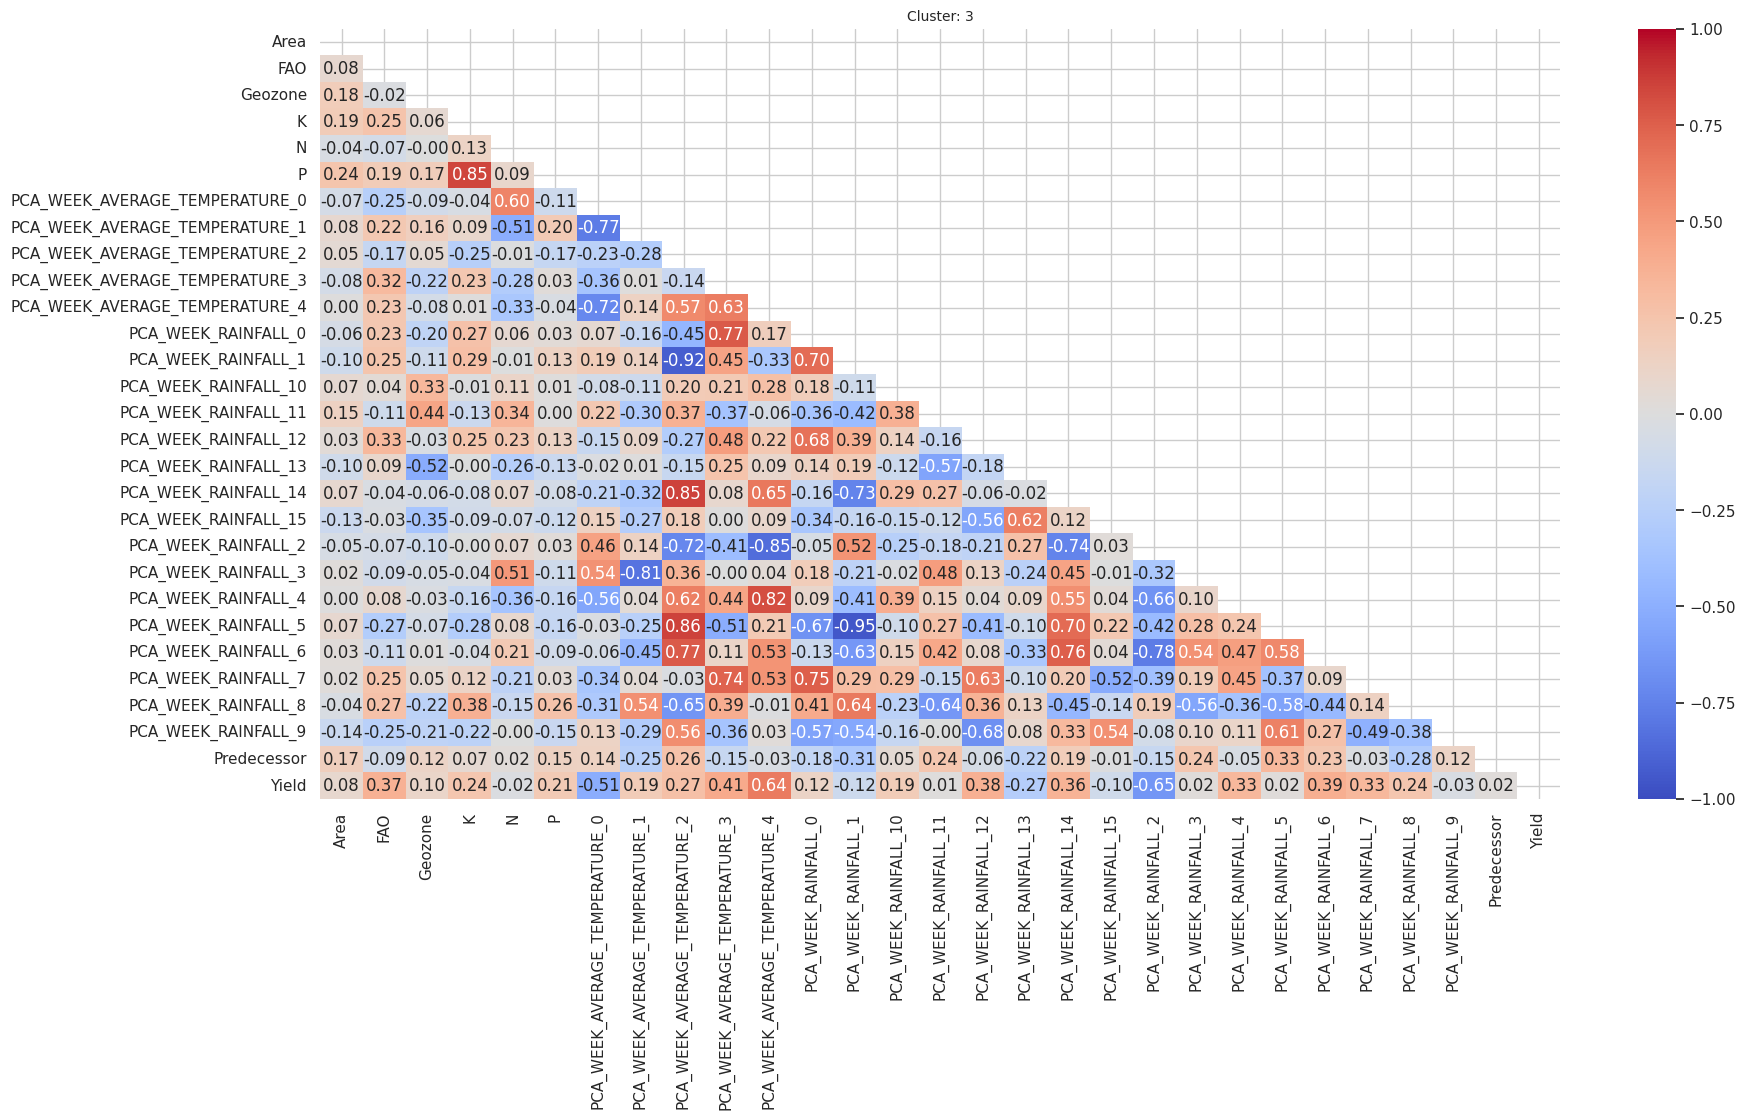

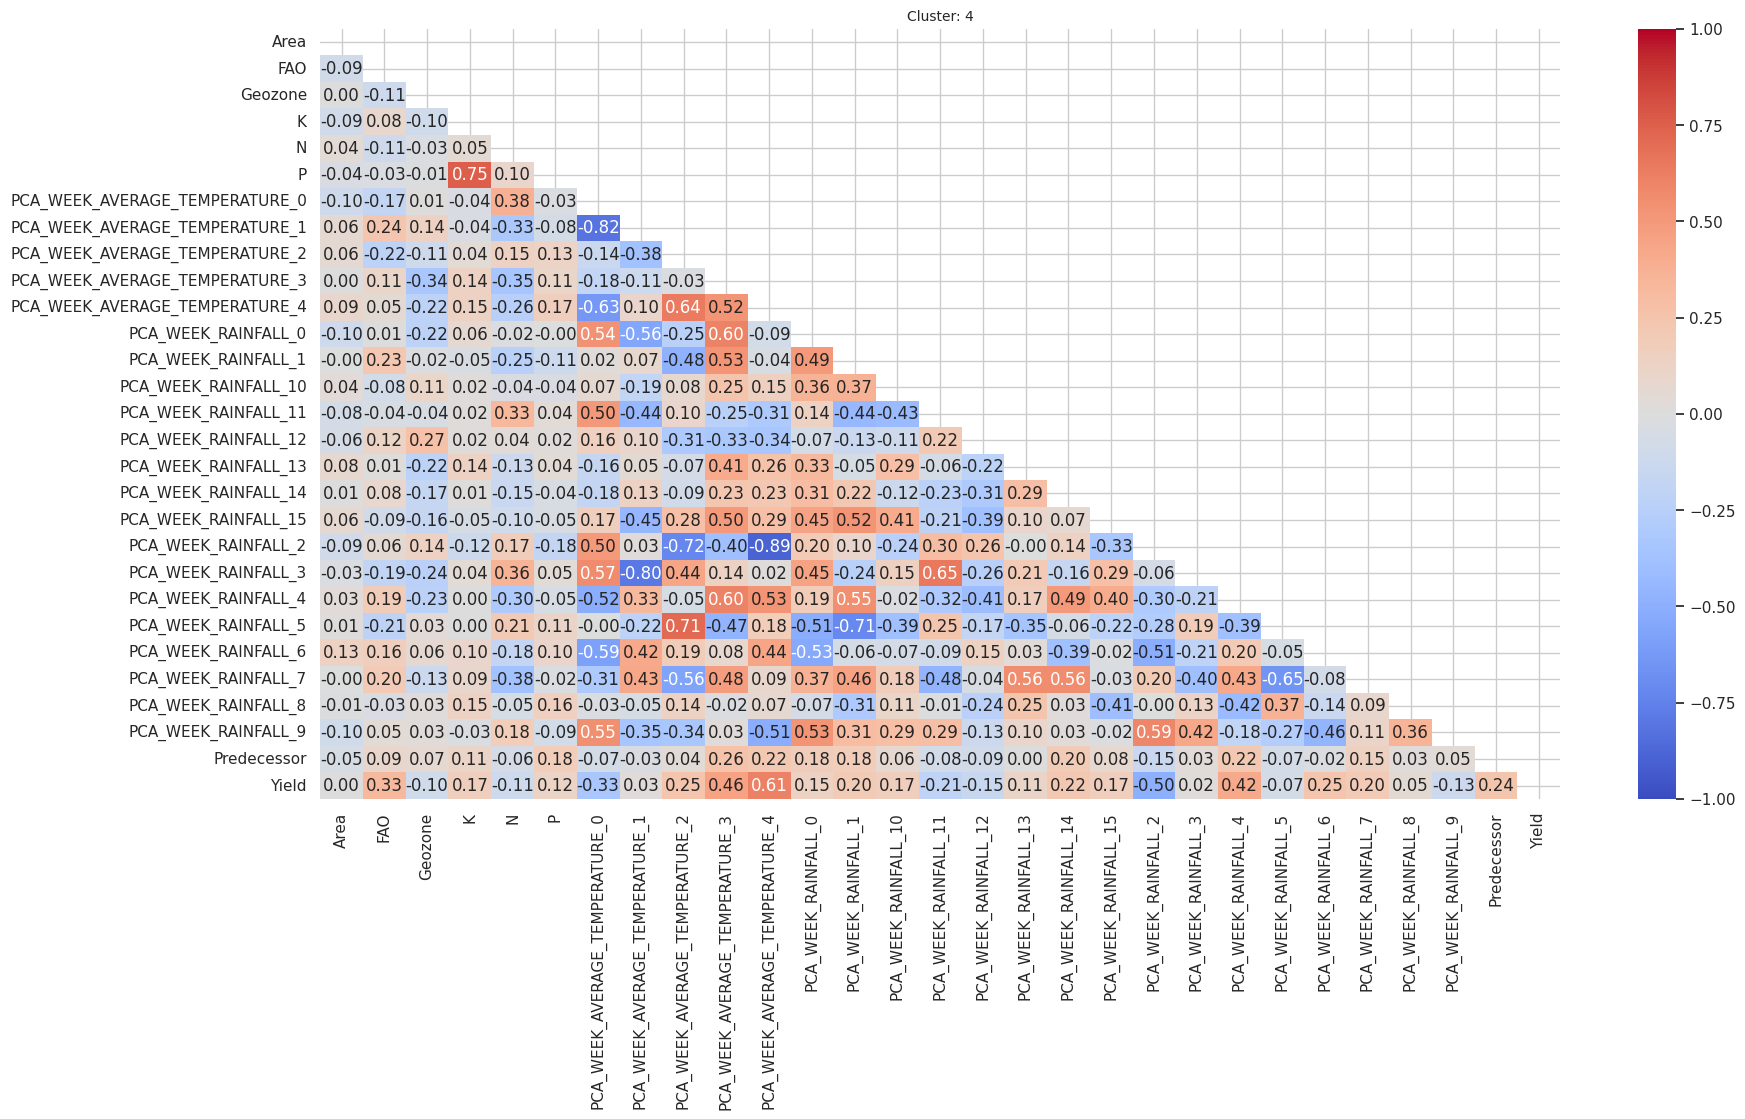

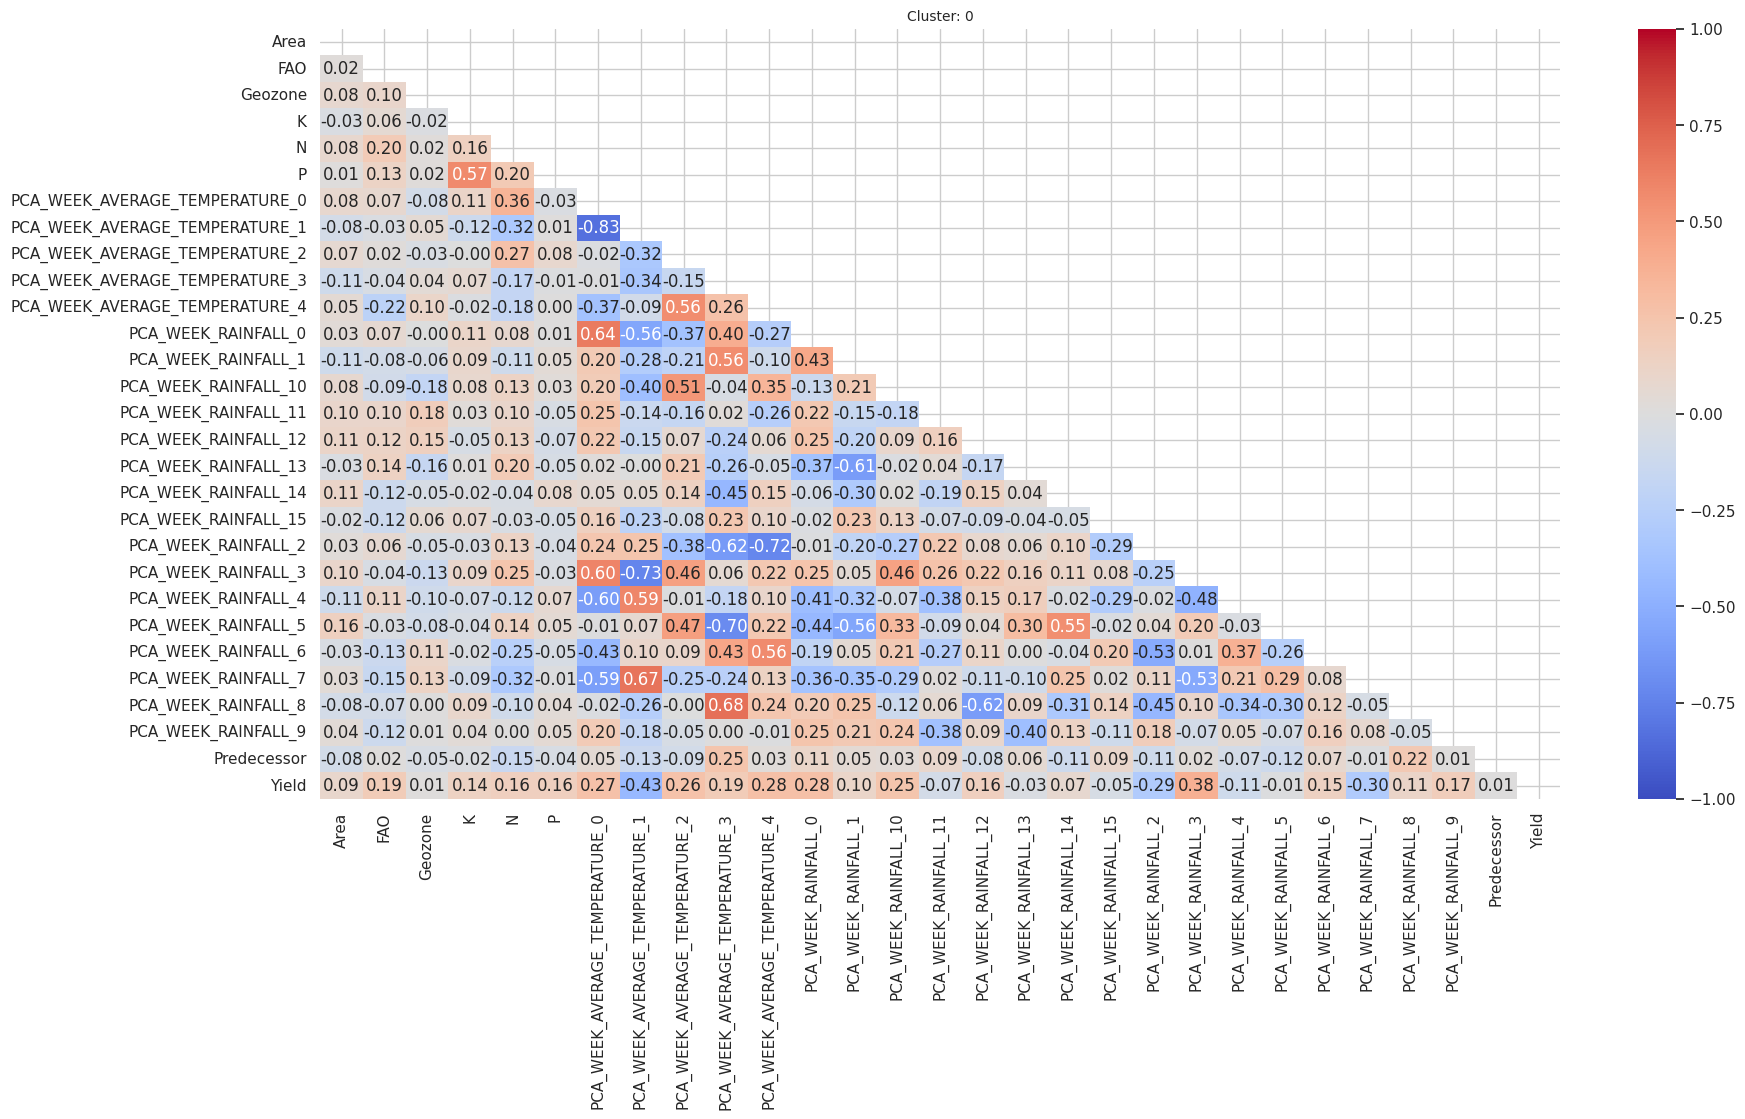

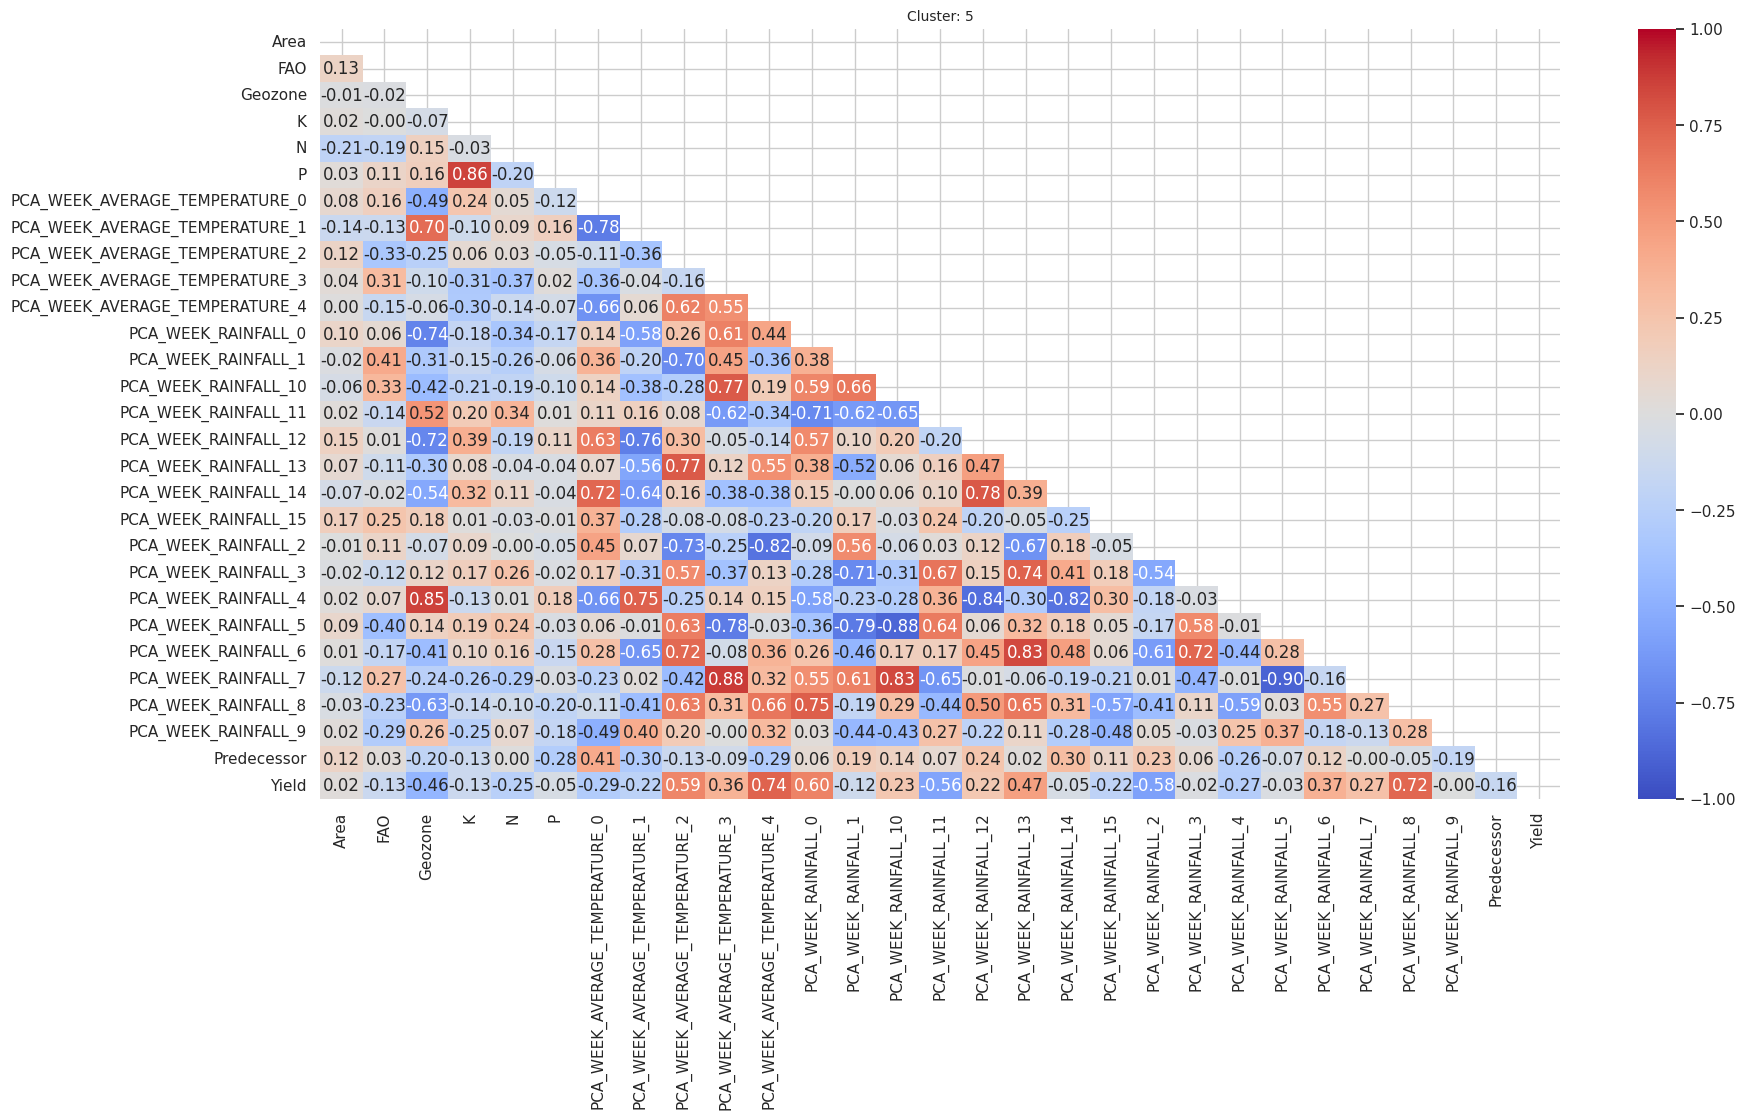

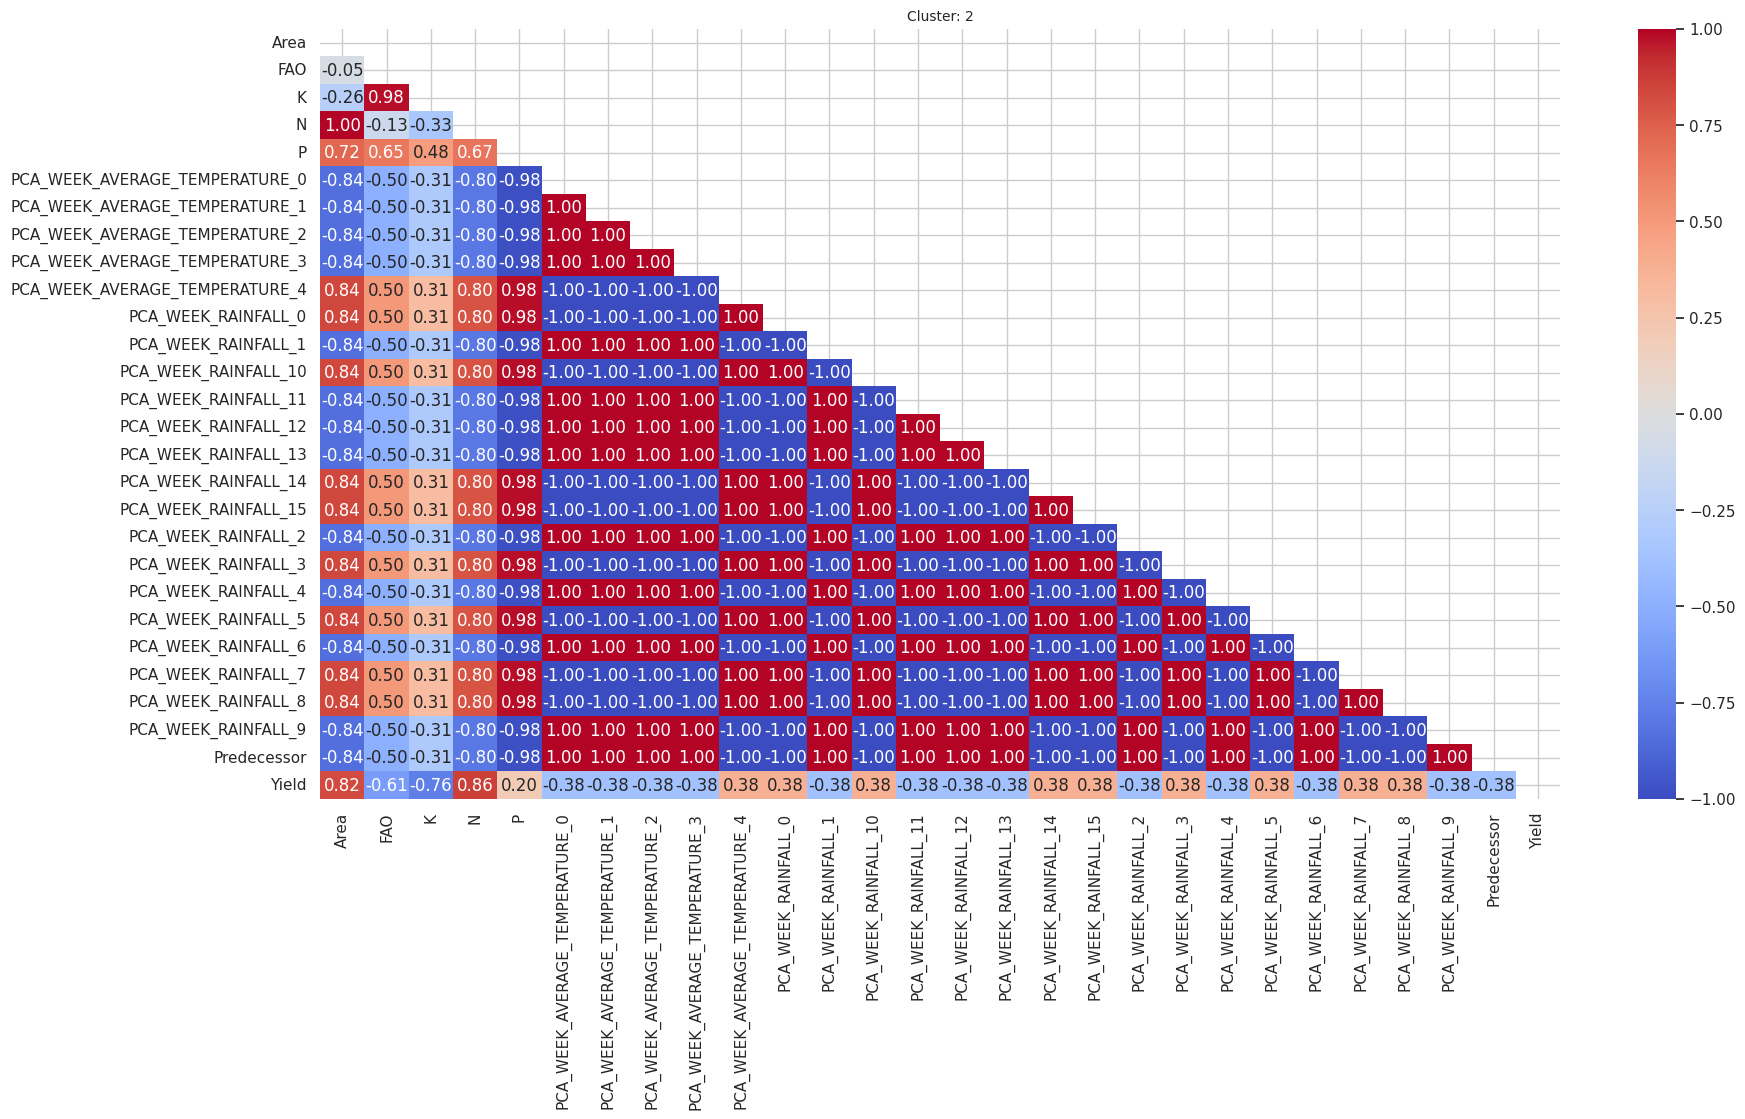

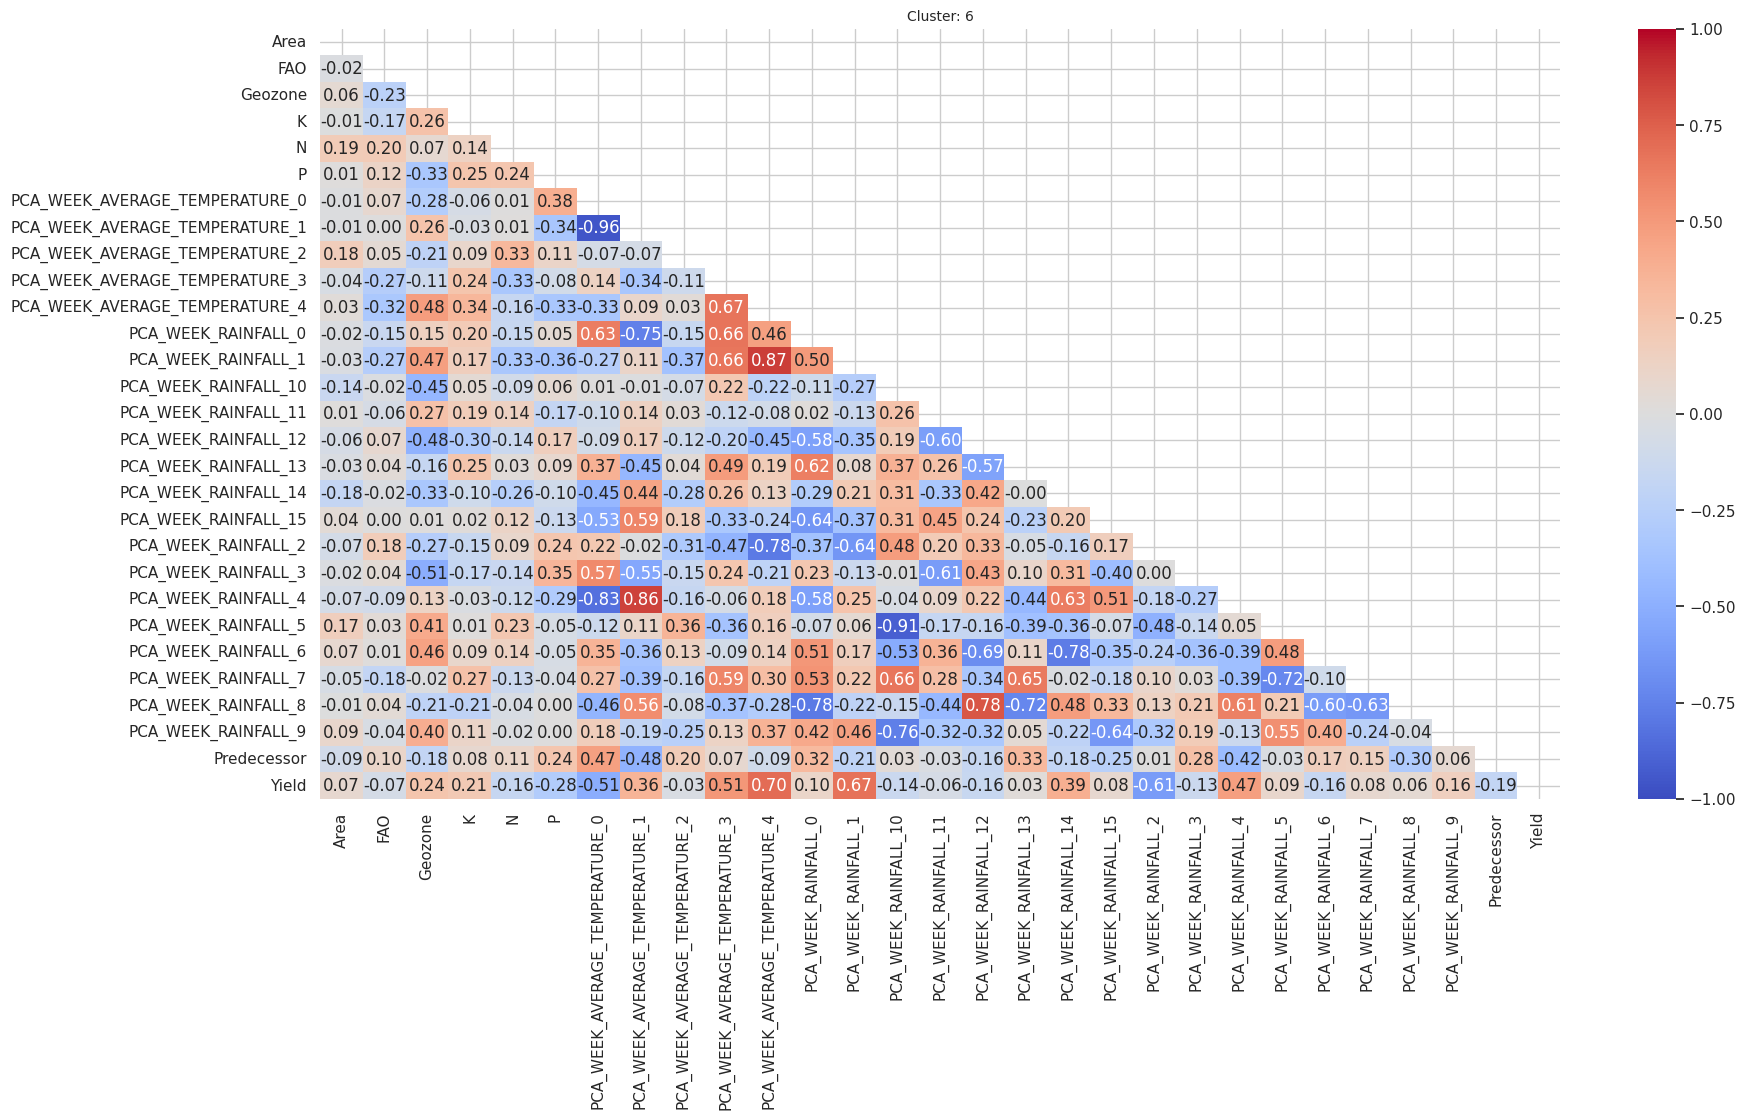

In [26]:
####### CHECK TRAIN DATASET CORRELATION MATRIX ##############################

def CorrMatr(df, corr_threshold = 0.0):

    # # calculating the raw correlation matrix
    raw_correlation = df.corr()

    # only keeping the lower diagonal
    correlation = raw_correlation.copy()
    mask = np.zeros_like(correlation, dtype=bool)
    mask[np.triu_indices_from(mask)] = True
    correlation[mask] = np.nan

    # function to filter the correlation matrix by features that have correlation values above a certain threshold
    def correlation_threshold_filter(df, threshold):
        passed = set()
        for r, c in combinations(df.columns, 2):
            if (abs(df.loc[r, c]) >= threshold):
                passed.add(r)
                passed.add(c)
        passed = sorted(passed)
        return df.loc[passed, passed]


    correlation = correlation_threshold_filter(raw_correlation, 0.0)

    # only keeping the lower diagonal
    mask = np.zeros_like(correlation, dtype=bool)
    mask[np.triu_indices_from(mask)] = True
    correlation[mask] = np.nan

    return correlation

features = temp_train.columns
# print(features)

feature_to_exclude = ['Dataset', 'Field', 'Year', 'Yield']
corr_fetures_list = [item for item in list(features) if item not in feature_to_exclude]


#### DROP BAD CLUSTER 2 ################
# temp_train = temp_train[ temp_train['Cluster'] != 2 ]

for ii in temp_train['Cluster'].unique():
    filtered_df = temp_train.loc[(temp_train['Cluster'] == ii), corr_fetures_list + ['Yield']]

    corr_threshold = 0.5
    correlation = CorrMatr(filtered_df, corr_threshold)

    fig, ax = plt.subplots(1, 1 , figsize=(20, 10))
    sns.heatmap(correlation, annot=True, fmt='0.2f', cmap='coolwarm', ax=ax, vmin=-1, vmax=1).set_title(f'Cluster: {ii}', fontsize=10);


In [27]:
########## SETUP & EXPERIMENT WITH CATEGORICAL FEATURES ###############################

train = []
test = []

data_data = pd.concat([temp_train, temp_test], axis=0)

temp_train = []
temp_test = []

# display(data_data)
###### SETUP CATEGORICAL COLUMNS ####################

# category_claster = data_data['Cluster'].unique()
# category_geozone = data_data['Geozone'].unique()
# category_predecessor = data_data['Predecessor'].unique()    

data_data['Cluster'] = pd.Categorical(data_data['Cluster'], categories=data_data['Cluster'].unique())
data_data['Geozone'] = pd.Categorical(data_data['Geozone'], categories=data_data['Geozone'].unique())
data_data['Predecessor'] = pd.Categorical(data_data['Predecessor'], categories=data_data['Predecessor'].unique()  )

######## SETUP CAT_FEATURES, need for CatBoost ##########################
cat_features=['Cluster', 'Geozone', 'Predecessor']
# cat_features=['Cluster', 'Geozone']
# cat_features=['Geozone']


######### CHECK DATASET FOR CATEGORICAL ################################
display(data_data)

# Display all column names and their data types
column_info = data_data.dtypes.reset_index()
column_info.columns = ['Column Name', 'Data Type']

# Check if each column is categorical or not
column_info['Is Categorical'] = column_info['Data Type'].astype(str).str.startswith('category')

display(column_info[0:20])

# fn

Dataset  Field  Year Cluster     Area       Yield Geozone Predecessor  \
0      train   1310  2019       1   79.263  129.077355      12           0   
1      train   1315  2018       1  115.484  190.068235      12           0   
2      train   1315  2019       1   83.883  149.674818      12           0   
3      train   1312  2018       1   55.964  181.336145      12           0   
4      train   1312  2019       1   55.965  148.165017      12           0   
...      ...    ...   ...     ...      ...         ...     ...         ...   
7920    test    291  2020       6   34.607    0.000000      19           1   
7922    test   3002  2020       5  102.733    0.000000      42           1   
7923    test   3000  2020       5  111.347    0.000000      42           1   
7924    test   3001  2020       5  152.212    0.000000      42           1   
7925    test   2999  2020       5   64.231    0.000000      42           1   

        FAO           N  ...  PCA_WEEK_RAINFALL_6  PCA_WEEK_RAINFALL_7  \
0     320.0  222.330633  ...            -0.310412             2.539740   
1     360.0  202.932162  ...            -0.362056            -0.250815   
2     320.0  229.686158  ...            -0.310412             2.539740   
3     360.0  209.345544  ...            -0.362056            -0.250815   
4     320.0  204.983972  ...            -0.310412             2.539740   
...     ...         ...  ...                  ...                  ...   
7920  360.0  187.967348  ...             0.280887            -0.011320   
7922  320.0  106.382623  ...            -0.424417             0.044493   
7923  320.0  100.968073  ...            -0.424417             0.044493   
7924  320.0  103.299175  ...            -0.424417             0.044493   
7925  320.0  102.993072  ...            -0.424417             0.044493   

      PCA_WEEK_RAINFALL_8  PCA_WEEK_RAINFALL_9  PCA_WEEK_RAINFALL_10  \
0               -0.655636             0.557575             -0.379517   
1                1.330279            -0.343780             -0.542347   
2               -0.655636             0.557575             -0.379517   
3                1.330279            -0.343780             -0.542347   
4               -0.655636             0.557575             -0.379517   
...                   ...                  ...                   ...   
7920            -0.114263            -0.459481             -0.524804   
7922             0.006906             0.793332              0.778515   
7923             0.006906             0.793332              0.778515   
7924             0.006906             0.793332              0.778515   
7925             0.006906             0.793332              0.778515   

      PCA_WEEK_RAINFALL_11  PCA_WEEK_RAINFALL_12  PCA_WEEK_RAINFALL_13  \
0                -0.476590              1.234538             -0.174132   
1                 0.218719              0.318988             -0.280926   
2                -0.476590              1.234538             -0.174132   
3                 0.218719              0.318988             -0.280926   
4                -0.476590              1.234538             -0.174132   
...                    ...                   ...                   ...   
7920             -0.464541              0.086617              0.590493   
7922              0.150972              0.323888              0.423649   
7923              0.150972              0.323888              0.423649   
7924              0.150972              0.323888              0.423649   
7925              0.150972              0.323888              0.423649   

      PCA_WEEK_RAINFALL_14  PCA_WEEK_RAINFALL_15  
0                -0.285303              0.697826  
1                -0.119749             -0.458109  
2                -0.285303              0.697826  
3                -0.119749             -0.458109  
4                -0.285303              0.697826  
...                    ...                   ...  
7920             -0.342554             -1.247034  
7922             

Column Name Data Type  Is Categorical
0                          Dataset    object           False
1                            Field     int64           False
2                             Year     int64           False
3                          Cluster  category            True
4                             Area   float64           False
5                            Yield   float64           False
6                          Geozone  category            True
7                      Predecessor  category            True
8                              FAO   float64           False
9                                N   float64           False
10                               P   float64           False
11                               K   float64           False
12  PCA_WEEK_AVERAGE_TEMPERATURE_0   float64           False
13  PCA_WEEK_AVERAGE_TEMPERATURE_1   float64           False
14  PCA_WEEK_AVERAGE_TEMPERATURE_2   float64           False
15  PCA_WEEK_AVERAGE_TEMPERATURE_3   float64           False
16  PCA_WEEK_AVERAGE_TEMPERATURE_4   float64           False
17             PCA_WEEK_RAINFALL_0   float64           False
18             PCA_WEEK_RAINFALL_1   float64           False
19             PCA_WEEK_RAINFALL_2   float64           False

In [28]:
######## SPLIT TRAIN/TEST FROM TRAIN DATASET FOR TRAIN & CROSS_VALIDATION ###################################
train = data_data[ data_data['Dataset'] == 'train' ]

target_name = 'Yield'
features_to_exclude = ['Dataset', 'Field', 'Year'] + [target_name]

all_features = list(train.columns)
features_to_include = list(set(all_features) - set(features_to_exclude))

print(f'all_features: {len(all_features)} : {all_features}')
print(f'features_to_exclude: {len(features_to_exclude)} : {features_to_exclude}')
print(f'features_to_include: {len(features_to_include)} : {features_to_include}')

# splitting training data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(train[features_to_include],
                                                    train[[target_name]],
                                                    train_size=0.80,
                                                    shuffle=True,
                                                    random_state=1)

print(f'Size of X_train: {X_train.shape}\nSize of y_train: {y_train.shape}')
print(f'Size of X_test: {X_test.shape}\nSize of y_test: {y_test.shape}')

all_features: 33 : ['Dataset', 'Field', 'Year', 'Cluster', 'Area', 'Yield', 'Geozone', 'Predecessor', 'FAO', 'N', 'P', 'K', 'PCA_WEEK_AVERAGE_TEMPERATURE_0', 'PCA_WEEK_AVERAGE_TEMPERATURE_1', 'PCA_WEEK_AVERAGE_TEMPERATURE_2', 'PCA_WEEK_AVERAGE_TEMPERATURE_3', 'PCA_WEEK_AVERAGE_TEMPERATURE_4', 'PCA_WEEK_RAINFALL_0', 'PCA_WEEK_RAINFALL_1', 'PCA_WEEK_RAINFALL_2', 'PCA_WEEK_RAINFALL_3', 'PCA_WEEK_RAINFALL_4', 'PCA_WEEK_RAINFALL_5', 'PCA_WEEK_RAINFALL_6', 'PCA_WEEK_RAINFALL_7', 'PCA_WEEK_RAINFALL_8', 'PCA_WEEK_RAINFALL_9', 'PCA_WEEK_RAINFALL_10', 'PCA_WEEK_RAINFALL_11', 'PCA_WEEK_RAINFALL_12', 'PCA_WEEK_RAINFALL_13', 'PCA_WEEK_RAINFALL_14', 'PCA_WEEK_RAINFALL_15']
features_to_exclude: 4 : ['Dataset', 'Field', 'Year', 'Yield']
features_to_include: 29 : ['PCA_WEEK_RAINFALL_10', 'PCA_WEEK_RAINFALL_6', 'PCA_WEEK_RAINFALL_11', 'PCA_WEEK_RAINFALL_8', 'PCA_WEEK_RAINFALL_1', 'PCA_WEEK_RAINFALL_13', 'N', 'P', 'PCA_WEEK_RAINFALL_7', 'Cluster', 'FAO', 'PCA_WEEK_AVERAGE_TEMPERATURE_3', 'Geozone', 'PCA_

In [29]:
############# START WITH XGBoost BASELINE WITH RANDOM_NOISE FOR REMOVE NOISY FEATURES, wwith low impact #####################
X_baseline = X_train
y_baseline = y_train

################## FOR CUT LOW IMPORTANCE FEATURES ####################
X_baseline['random_noise'] = np.random.normal(size=X_train.shape[0])

# create a baseline model to compare with
baseline_model = XGBRegressor(gamma=5, reg_lambda=5, enable_categorical=True, max_cat_to_onehot=7) # quickly add in some regularization by trial and error to prevent extreme overfitting
# cv_results = cross_validate(baseline_model, X_baseline, y_baseline, cv=10, scoring='neg_mean_absolute_error', return_train_score=True)
cv_results = cross_validate(baseline_model, X_baseline, y_baseline, cv=10, scoring='r2', return_train_score=True)
mean_test_score = np.mean(cv_results['test_score'])
train_test_score_rmse = np.sqrt(np.sum((cv_results['test_score'] - cv_results['train_score']) ** 2) / cv_results['test_score'].shape[0]) # helpful for minimizing overfitting

# print scoring metrics
print(f'Test Scores on K-Folds: ', str(np.round(cv_results['test_score'], decimals=3)))
print(f'Train Scores on K-Folds: ', str(np.round(cv_results['train_score'], decimals=3)))
print(f'Mean Test Score: {np.round(mean_test_score, decimals=3)}')
print(f'Train/Test Score MAPE: {np.round(train_test_score_rmse, decimals=3)}')

Test Scores on K-Folds:  [0.636 0.719 0.712 0.7   0.687 0.783 0.678 0.705 0.723 0.704]
Train Scores on K-Folds:  [0.982 0.985 0.982 0.983 0.983 0.98  0.984 0.982 0.982 0.982]
Mean Test Score: 0.705
Train/Test Score MAPE: 0.28


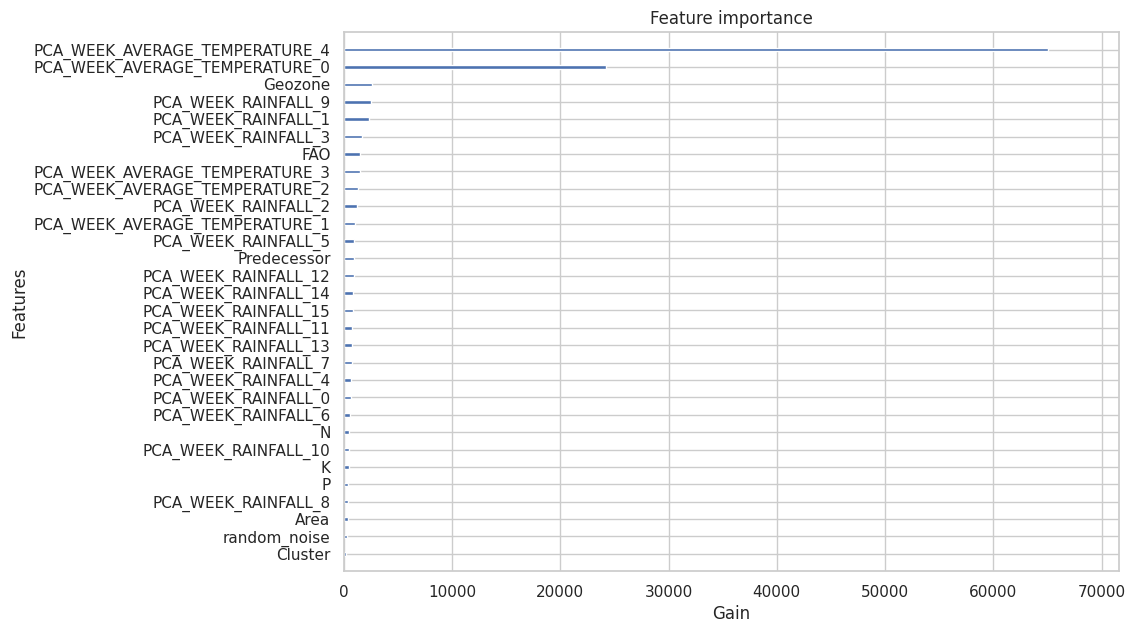

In [30]:
############ PLOT FEATURES IMPORTANSE WITH RANDOM_NOISE #########################
fig, ax = plt.subplots(figsize=(10, 7))
baseline_model.fit(X_baseline, y_baseline)
plot_importance(baseline_model, ax=ax, importance_type='gain', show_values=False, xlabel='Gain', max_num_features=40);

In [31]:
##### DROP FEATURES WITH IMPORTANCE LOWER THAN RANDOM NOISE #################################

importance_dict = baseline_model.get_booster().get_score(importance_type='gain')

# Sort the dictionary by values in descending order
importance_dict = dict(sorted(importance_dict.items(), key=lambda item: item[1], reverse=True))

print(importance_dict)

# Specify the random_noise value
random_noise_value = importance_dict.get('random_noise')  

# Remove keys with values less than random_noise_value
filtered_dict = {key: value for key, value in importance_dict.items() if value > random_noise_value}

# Display the filtered dictionary
print("Filtered Dictionary:")
print(filtered_dict)

# fn

{'PCA_WEEK_AVERAGE_TEMPERATURE_4': 65084.625, 'PCA_WEEK_AVERAGE_TEMPERATURE_0': 24216.517578125, 'Geozone': 2651.595458984375, 'PCA_WEEK_RAINFALL_9': 2492.94482421875, 'PCA_WEEK_RAINFALL_1': 2330.530517578125, 'PCA_WEEK_RAINFALL_3': 1717.7578125, 'FAO': 1526.0172119140625, 'PCA_WEEK_AVERAGE_TEMPERATURE_3': 1525.89013671875, 'PCA_WEEK_AVERAGE_TEMPERATURE_2': 1280.9512939453125, 'PCA_WEEK_RAINFALL_2': 1265.3355712890625, 'PCA_WEEK_AVERAGE_TEMPERATURE_1': 1058.835693359375, 'PCA_WEEK_RAINFALL_5': 986.7105712890625, 'Predecessor': 936.669677734375, 'PCA_WEEK_RAINFALL_12': 920.0972900390625, 'PCA_WEEK_RAINFALL_14': 852.7568969726562, 'PCA_WEEK_RAINFALL_15': 834.5690307617188, 'PCA_WEEK_RAINFALL_11': 748.8125, 'PCA_WEEK_RAINFALL_13': 741.3521728515625, 'PCA_WEEK_RAINFALL_7': 718.4012451171875, 'PCA_WEEK_RAINFALL_4': 675.3923950195312, 'PCA_WEEK_RAINFALL_0': 673.0725708007812, 'PCA_WEEK_RAINFALL_6': 574.8345336914062, 'N': 517.3711547851562, 'PCA_WEEK_RAINFALL_10': 517.3631591796875, 'K': 468

In [32]:
###### MANUALY DROP FEATURES ##################
# low_impact_features = ['Dataset', 'Field', 'Year', 'Area']
# features_to_exclude = low_impact_features + [target_name]

# all_features = list(train.columns)
# features_to_include = list(set(all_features) - set(features_to_exclude))

# GET FEATURES FROM FILTERED IMPORTANCE DICT ####################
features_to_include = list(filtered_dict.keys())

print(f'all_features: {len(all_features)} : {all_features}')
print('----------------')
print(f'features_to_exclude: {len(features_to_exclude)} : {features_to_exclude}')
print('----------------')
print(f'features_to_include: {len(features_to_include)} : {features_to_include}')
print('----------------')
print(f'Target: {target_name}')
print('----------------')

X_train, X_test, y_train, y_test = train_test_split(train[features_to_include],
                                                    train[target_name],
                                                    train_size=0.80,
                                                    shuffle=True,
                                                    random_state=1)

print(f'Size of X_train: {X_train.shape}\nSize of y_train: {y_train.shape}')
print(f'Size of X_test: {X_test.shape}\nSize of y_test: {y_test.shape}')

all_features: 33 : ['Dataset', 'Field', 'Year', 'Cluster', 'Area', 'Yield', 'Geozone', 'Predecessor', 'FAO', 'N', 'P', 'K', 'PCA_WEEK_AVERAGE_TEMPERATURE_0', 'PCA_WEEK_AVERAGE_TEMPERATURE_1', 'PCA_WEEK_AVERAGE_TEMPERATURE_2', 'PCA_WEEK_AVERAGE_TEMPERATURE_3', 'PCA_WEEK_AVERAGE_TEMPERATURE_4', 'PCA_WEEK_RAINFALL_0', 'PCA_WEEK_RAINFALL_1', 'PCA_WEEK_RAINFALL_2', 'PCA_WEEK_RAINFALL_3', 'PCA_WEEK_RAINFALL_4', 'PCA_WEEK_RAINFALL_5', 'PCA_WEEK_RAINFALL_6', 'PCA_WEEK_RAINFALL_7', 'PCA_WEEK_RAINFALL_8', 'PCA_WEEK_RAINFALL_9', 'PCA_WEEK_RAINFALL_10', 'PCA_WEEK_RAINFALL_11', 'PCA_WEEK_RAINFALL_12', 'PCA_WEEK_RAINFALL_13', 'PCA_WEEK_RAINFALL_14', 'PCA_WEEK_RAINFALL_15']
----------------
features_to_exclude: 4 : ['Dataset', 'Field', 'Year', 'Yield']
----------------
features_to_include: 28 : ['PCA_WEEK_AVERAGE_TEMPERATURE_4', 'PCA_WEEK_AVERAGE_TEMPERATURE_0', 'Geozone', 'PCA_WEEK_RAINFALL_9', 'PCA_WEEK_RAINFALL_1', 'PCA_WEEK_RAINFALL_3', 'FAO', 'PCA_WEEK_AVERAGE_TEMPERATURE_3', 'PCA_WEEK_AVERAGE_T

In [33]:
#### CHECK IMPROVEMENTS WITH DROPPED LOW IMPORTANCE FEATURES ###################
# get train and test data
X_baseline = X_train
y_baseline = y_train

# analyze baseline model with refined data
# cv_results = cross_validate(baseline_model, X_baseline, y_baseline, cv=10, scoring='neg_mean_absolute_error', return_train_score=True)
cv_results = cross_validate(baseline_model, X_baseline, y_baseline, cv=10, scoring='r2', return_train_score=True)
mean_test_score = np.mean(cv_results['test_score'])
train_test_score_rmse = np.sqrt(np.sum((cv_results['test_score'] - cv_results['train_score']) ** 2) / cv_results['test_score'].shape[0]) # helpful for minimizing overfitting

# print scoring metrics
print('Test Scores on K-Folds: ', str(np.round(cv_results['test_score'], decimals=3)))
print('Train Scores on K-Folds: ', str(np.round(cv_results['train_score'], decimals=3)))
print(f'Mean Test Score: {np.round(mean_test_score, decimals=3)}')
print(f'Train/Test Score K-Fold RMSE: {np.round(train_test_score_rmse, decimals=3)}')

Test Scores on K-Folds:  [0.67  0.722 0.716 0.707 0.699 0.779 0.675 0.7   0.712 0.697]
Train Scores on K-Folds:  [0.978 0.978 0.98  0.978 0.98  0.978 0.979 0.98  0.979 0.978]
Mean Test Score: 0.708
Train/Test Score K-Fold RMSE: 0.273


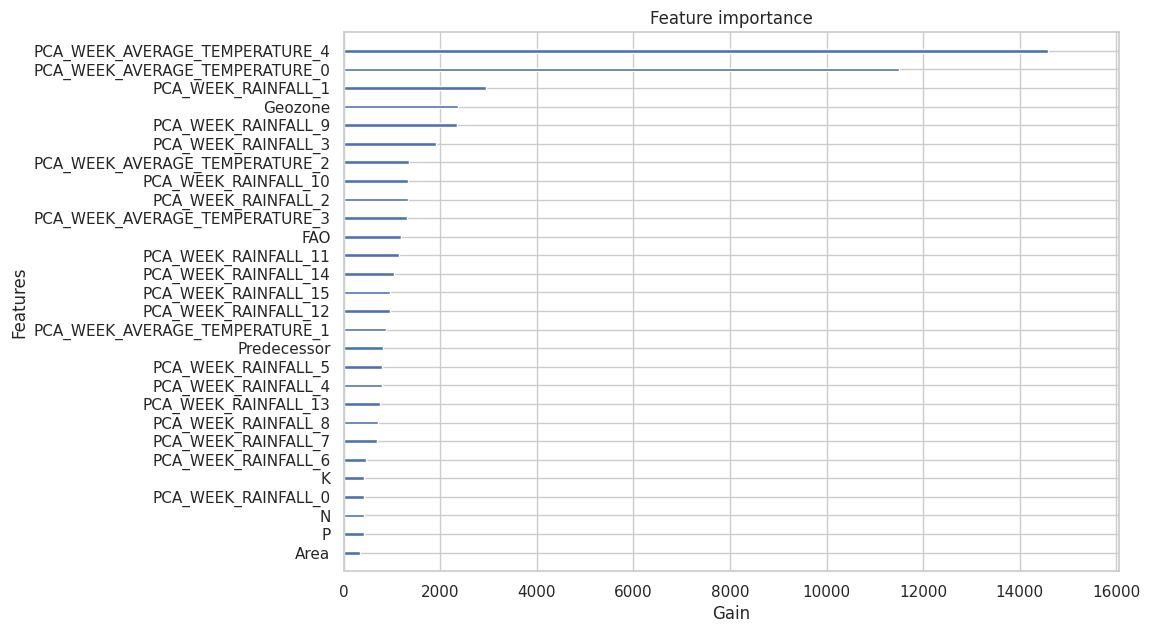

In [34]:
############ PLOT FEATURES IMPORTANSE WITHOUT FEATURES LOWER IMPORTANCE THEN RANDOM_NOISE #########################
fig, ax = plt.subplots(figsize=(10, 7))
baseline_model.fit(X_baseline, y_baseline)
plot_importance(baseline_model, ax=ax, importance_type='gain', show_values=False, xlabel='Gain', max_num_features=40);

In [35]:
######## GET LIST WITH CATEGORICAL FEATURES IN DATASET, some can be dropeed, update them for CatBoost inputs #########
cat_features = train[features_to_include].select_dtypes(include='category').columns.tolist()

######################## CATBOOST PROBE ###################
cb_model = CatBoostRegressor(iterations=200, silent=True, cat_features=cat_features)
cv_results = cross_validate(cb_model, X_baseline, y_baseline, cv=10, scoring='r2', return_train_score=True)
mean_test_score = np.mean(cv_results['test_score'])
train_test_score_rmse = np.sqrt(np.sum((cv_results['test_score'] - cv_results['train_score']) ** 2) / cv_results['test_score'].shape[0]) 

print('Test Scores on K-Folds: ', str(np.round(cv_results['test_score'], decimals=3)))
print('Train Scores on K-Folds: ', str(np.round(cv_results['train_score'], decimals=3)))
print(f'Mean Test Score: {np.round(mean_test_score, decimals=3)}')
print(f'Train/Test Score [RMSE]: {np.round(train_test_score_rmse, decimals=3)}')

Test Scores on K-Folds:  [0.636 0.73  0.743 0.687 0.716 0.773 0.701 0.711 0.701 0.72 ]
Train Scores on K-Folds:  [0.868 0.861 0.859 0.86  0.86  0.86  0.857 0.864 0.852 0.858]
Mean Test Score: 0.712
Train/Test Score [RMSE]: 0.152


In [36]:
# XGBoost FINE-TUNING WITH OPTUNA ########################
def objective(trial):
    
    regressor = XGBRegressor(n_estimators=trial.suggest_int('n_estimators', 70, 1000),
                             max_depth=trial.suggest_int('max_depth', 2, 6),
                             min_child_weight=trial.suggest_float('min_child_weight', 0, 6),
                             gamma=trial.suggest_float('gamma', 0, 6),
                             learning_rate=trial.suggest_float('learning_rate', 0.001, 0.3),
                             subsample=trial.suggest_float('subsample', 0.50, 1),
                             colsample_bytree=trial.suggest_float('colsample_bytree', 0.5, 1),
                             reg_lambda=trial.suggest_float('reg_lambda', 0, 5),
                             enable_categorical=True, max_cat_to_onehot=7)

    train_scores = []
    test_scores = []

    cv_results = cross_validate(regressor, X_train, y_train, cv=10, scoring='r2', return_train_score=True)
    mean_test_score = np.mean(cv_results['test_score'])
    train_test_score_rmse = np.sqrt(np.sum((cv_results['test_score'] - cv_results['train_score']) ** 2) / cv_results['test_score'].shape[0])

    return mean_test_score, train_test_score_rmse

optuna.logging.set_verbosity(optuna.logging.WARNING)
cv_study = optuna.create_study(directions=['maximize', 'minimize'])
cv_study.optimize(objective, n_trials=20)

study_results_zipped = [(hyper.values[0], hyper.values[1], hyper.params) for hyper in cv_study.best_trials]
ordered_study_results = sorted(study_results_zipped, key=lambda x: x[1])

min_max_list = []
max

for i, hyper in enumerate(ordered_study_results):
    print(f'Model {i} Results:')
    print(f'Mean Test Score: {np.round(hyper[0], decimals=3)}\nTrain/Test Score [RMSE]: {np.round(hyper[1], decimals=3)}')
    print(hyper[2])
    print('\n')

    min_max_list.append(np.round(hyper[0], decimals=3))

print(min_max_list)


Model 0 Results:
Mean Test Score: 0.704
Train/Test Score [RMSE]: 0.087
{'n_estimators': 633, 'max_depth': 3, 'min_child_weight': 0.5709241788865547, 'gamma': 4.339388244625576, 'learning_rate': 0.020409512533551583, 'subsample': 0.9374579726736144, 'colsample_bytree': 0.9585904043069533, 'reg_lambda': 4.733519407997145}


Model 1 Results:
Mean Test Score: 0.72
Train/Test Score [RMSE]: 0.113
{'n_estimators': 381, 'max_depth': 4, 'min_child_weight': 4.329374372567209, 'gamma': 2.484565000519705, 'learning_rate': 0.034322418242734035, 'subsample': 0.809973694184966, 'colsample_bytree': 0.6991910617842483, 'reg_lambda': 3.3919588994546124}


Model 2 Results:
Mean Test Score: 0.722
Train/Test Score [RMSE]: 0.151
{'n_estimators': 489, 'max_depth': 3, 'min_child_weight': 1.3361230728048368, 'gamma': 4.891798721794265, 'learning_rate': 0.09992250278630707, 'subsample': 0.7441679466730622, 'colsample_bytree': 0.7342168901342451, 'reg_lambda': 1.7587277194759836}


Model 3 Results:
Mean Test Sco

In [37]:
###### TODO: both parameters (Test Metric & Train/Test Metric) should be taken into account, for prevent overfitting
max_position = min_max_list.index(max(min_max_list))

hyper = ordered_study_results[max_position]

print('optimal model:', max_position, hyper)

optimal model: 4 (0.7345658034236322, 0.20386523724800043, {'n_estimators': 730, 'max_depth': 5, 'min_child_weight': 3.700065693387031, 'gamma': 0.8403499332752973, 'learning_rate': 0.03435494699574694, 'subsample': 0.8748033835798699, 'colsample_bytree': 0.7963829416268757, 'reg_lambda': 4.70645400035349})


In [38]:
########## FINAL XGBoost
xgb_final = XGBRegressor(n_estimators=hyper[2]['n_estimators'],
                         max_depth=hyper[2]['max_depth'],
                         min_child_weight=hyper[2]['min_child_weight'],
                         gamma=hyper[2]['gamma'],
                         learning_rate=hyper[2]['learning_rate'],
                         subsample=hyper[2]['subsample'],
                         colsample_bytree=hyper[2]['colsample_bytree'],
                         reg_lambda=hyper[2]['reg_lambda'],
                         enable_categorical=True, max_cat_to_onehot=7)

####### CROSS_VALIDATION
cv_results = cross_validate(xgb_final, X_train, y_train, cv=10, scoring='r2', return_train_score=True)
mean_test_score = np.mean(cv_results['test_score'])
train_test_score_rmse = np.sqrt(np.sum((cv_results['test_score'] - cv_results['train_score']) ** 2) / cv_results['test_score'].shape[0]) 

print('Test Scores on K-Folds: ', str(np.round(cv_results['test_score'], decimals=3)))
print('Train Scores on K-Folds: ', str(np.round(cv_results['train_score'], decimals=3)))
print(f'Mean Test Score: {np.round(mean_test_score, decimals=3)}')
print(f'Train/Test Score [RMSE]: {np.round(train_test_score_rmse, decimals=3)}')

Test Scores on K-Folds:  [0.668 0.748 0.75  0.736 0.734 0.798 0.712 0.737 0.732 0.731]
Train Scores on K-Folds:  [0.939 0.935 0.935 0.934 0.936 0.935 0.937 0.936 0.936 0.936]
Mean Test Score: 0.735
Train/Test Score [RMSE]: 0.204


In [39]:
################ CATBOOST FINE_TUNE ############
def objective(trial):
    
    regressor = CatBoostRegressor(iterations=trial.suggest_int('iterations', 100, 800),
                                  depth=trial.suggest_int('depth', 6, 10),
                                  l2_leaf_reg=trial.suggest_float('l2_leaf_reg', 0.0001, 0.1, log=True),
                                  silent=True, 
                                  cat_features=cat_features)       

    train_scores = []
    test_scores = []

    cv_results = cross_validate(regressor, X_train, y_train, cv=10, scoring='r2', return_train_score=True)
    mean_test_score = np.mean(cv_results['test_score'])
    train_test_score_rmse = np.sqrt(np.sum((cv_results['test_score'] - cv_results['train_score']) ** 2) / cv_results['test_score'].shape[0]) 
    
    return mean_test_score, train_test_score_rmse

# OPTIMIZATION
optuna.logging.set_verbosity(optuna.logging.WARNING) 
cv_study = optuna.create_study(directions=['maximize', 'minimize'])
cv_study.optimize(objective, n_trials=20)

min_max_list = []

study_results_zipped = [(hyper.values[0], hyper.values[1], hyper.params) for hyper in cv_study.best_trials]
ordered_study_results = sorted(study_results_zipped, key=lambda x: x[1])
for i, hyper in enumerate(ordered_study_results):
    print(f'Model {i} Results:')
    print(f'Mean Test Score: {np.round(hyper[0], decimals=3)}\nTrain/Test MAE K-Fold Score: {np.round(hyper[1], decimals=3)}')
    print(hyper[2])
    print('\n')

    min_max_list.append(np.round(hyper[0], decimals=3))

Model 0 Results:
Mean Test Score: 0.66
Train/Test MAE K-Fold Score: 0.057
{'iterations': 150, 'depth': 6, 'l2_leaf_reg': 0.0015110671456733072}


Model 1 Results:
Mean Test Score: 0.689
Train/Test MAE K-Fold Score: 0.077
{'iterations': 269, 'depth': 6, 'l2_leaf_reg': 0.0011961747757999587}


Model 2 Results:
Mean Test Score: 0.708
Train/Test MAE K-Fold Score: 0.102
{'iterations': 330, 'depth': 7, 'l2_leaf_reg': 0.0007678654742719113}


Model 3 Results:
Mean Test Score: 0.709
Train/Test MAE K-Fold Score: 0.105
{'iterations': 344, 'depth': 7, 'l2_leaf_reg': 0.041580686120247554}


Model 4 Results:
Mean Test Score: 0.716
Train/Test MAE K-Fold Score: 0.131
{'iterations': 686, 'depth': 6, 'l2_leaf_reg': 0.0006947282741128661}


Model 5 Results:
Mean Test Score: 0.719
Train/Test MAE K-Fold Score: 0.134
{'iterations': 518, 'depth': 7, 'l2_leaf_reg': 0.00036994369805617435}


Model 6 Results:
Mean Test Score: 0.721
Train/Test MAE K-Fold Score: 0.157
{'iterations': 480, 'depth': 8, 'l2_leaf_reg

In [40]:
max_position = min_max_list.index(max(min_max_list))

hyper = ordered_study_results[max_position]

print('optimal model:', max_position, hyper)


optimal model: 9 (0.7253461225396111, 0.17774289389433712, {'iterations': 654, 'depth': 8, 'l2_leaf_reg': 0.07876359356228842})


In [41]:
######## FINAL CatBoost 
cb_final = CatBoostRegressor(iterations=hyper[2]['iterations'],
                             depth=hyper[2]['depth'],
                             l2_leaf_reg=hyper[2]['l2_leaf_reg'],
                             silent=True, cat_features=cat_features)

cv_results = cross_validate(cb_final, X_baseline, y_baseline, cv=10, scoring='r2', return_train_score=True)
mean_test_score = np.mean(cv_results['test_score'])
train_test_score_rmse = np.sqrt(np.sum((cv_results['test_score'] - cv_results['train_score']) ** 2) / cv_results['test_score'].shape[0]) # helpful for minimizing overfitting

print('Test Scores on K-Folds: ', str(np.round(cv_results['test_score'], decimals=3)))
print('Train Scores on K-Folds: ', str(np.round(cv_results['train_score'], decimals=3)))
print(f'Mean Test Score: {np.round(mean_test_score, decimals=3)}')
print(f'Train/Test Score K-Fold RMSE: {np.round(train_test_score_rmse, decimals=3)}')

Test Scores on K-Folds:  [0.67  0.741 0.744 0.721 0.724 0.773 0.711 0.736 0.709 0.725]
Train Scores on K-Folds:  [0.906 0.901 0.901 0.902 0.902 0.9   0.899 0.902 0.901 0.897]
Mean Test Score: 0.725
Train/Test Score K-Fold RMSE: 0.178


In [42]:
#### ENSEMBLING XGBoost and CatBoost
stacked_model = StackingRegressor(estimators=[('xgb', xgb_final), ('cat', cb_final)], final_estimator=LinearRegression())

cv_results = cross_validate(stacked_model, X_train, y_train, cv=10, scoring='r2', return_train_score=True)
mean_test_score = np.mean(cv_results['test_score'])
train_test_score_rmse = np.sqrt(np.sum((cv_results['test_score'] - cv_results['train_score']) ** 2) / cv_results['test_score'].shape[0]) 

print('Test Scores on K-Folds: ', str(np.round(cv_results['test_score'], decimals=3)))
print('Train Scores on K-Folds: ', str(np.round(cv_results['train_score'], decimals=3)))
print(f'Mean Test Score: {np.round(mean_test_score, decimals=3)}')
print(f'Train/Test Score K-Fold RMSE: {np.round(train_test_score_rmse, decimals=3)}')        

Test Scores on K-Folds:  [0.674 0.751 0.753 0.735 0.736 0.793 0.718 0.743 0.728 0.734]
Train Scores on K-Folds:  [0.931 0.924 0.927 0.924 0.926 0.924 0.927 0.923 0.925 0.924]
Mean Test Score: 0.737
Train/Test Score K-Fold RMSE: 0.192


In [43]:
stacked_model.fit(X_train, y_train)

y_test_pred = stacked_model.predict(X_test)       

mae = mean_absolute_error(y_test, y_test_pred)
# mse = mean_squared_error(y_test, y_test_pred)
r2_score = r2_score(y_test, y_test_pred)
print(f'Test Data Score [MAE]: {np.round(mae, decimals=3)}')
print(f'Test Data Score [R2]:  {np.round(r2_score, decimals=3)}')

Test Data Score [MAE]: 13.898
Test Data Score [R2]:  0.745


In [44]:
####### TODO: SHAPE feature importance 



In [45]:
###### TODO: Final Submission 



In [46]:
fn

NameError: name 'fn' is not defined